# Important Factors in Obtaining Grant Funding from the National Institute of Neurological Disorders and Stroke
### Mary Gibbs & Dan Vitale

# Table of Contents
1. [Introduction](#introduction)
2. [Packages](#packages)

&nbsp; 3. [Data Collection](#datacollection) 
   * 3.1 [Combine ninds data](#dcninds)
   * 3.2 [Use ninds data to get scopus data](#dcnindsscopus)
   * 3.3 [Combine scopus data](#dcscopus) 

&nbsp; 4. [Data Cleaning](#datacleaning)
   * 4.1 [Clean ninds data](#cninds)
   * 4.2 [Clean affiliations data](#caff)
   * 4.3 [Clean coauthors data](#ccoauth)
   * 4.4 [Clean journals data](#cjour)
   * 4.5 [Clean scopus data](#cscopus)     

&nbsp; 5. [Feature Engineering](#featureengineering)
   * 5.1 [Feature engineer ninds data](#feninds)
   * 5.2 [Feature engineer affiliations data](#feaff)
   * 5.3 [Feature engineer coauthors data](#fecoauth)
   * 5.4 [Feature engineer journals data](#fejour)
   * 5.5 [Feature engineer scopus data](#fescopus)
   * 5.6 [Model data](#md)
   
&nbsp; 6. [Exploratory Data Analysis](#eda)
   * 6.1 [Explore ninds data](#eninds)
   * 6.2 [Explore affiliations data](#eaff)
   * 6.3 [Explore coauthors data](#ecoauth)
   * 6.4 [Explore journals data](#ejour)
   * 6.5 [Explore scopus data](#escopus)

&nbsp; 7. [Feature Importance & Models](#fim)
   * 7.1 [Lasso regression](#lr)
   * 7.2 [Random forest regressor](#rfr)
   * 7.3 [Random forest classifier](#rfc)
   * 7.4 [Common important features](#cif)

&nbsp; 7. [Interpretation & Future Directions](#ifd)

<a id="introduction"></a>
## Introduction
The National Institutes of Health (NIH) is a biomedical research agency that was created to, “to seek fundamental knowledge about the nature and behavior of living systems and the application of that knowledge to enhance health, lengthen life, and reduce illness and disability.” To carry out this mission, the NIH invests billions of dollars each year in biomedical research. About 80% of the NIH's budget is awarded through almost 50,000 competitive grants to more than 300,000 researchers at more than 2,500 research institutions in the United States and around the world. Close to 10% of the NIH’s budget is utilized for projects conducted within its own laboratories. 

The NIH employs a peer review system in which a committee of scientists evaluates grant applications on criteria, such as approach, innovation, and significance. Subsequently, these grant application evaluations lead to grant funding awards. Previous literature reveals bias and disparities in this grant funding mechanism. An analysis of ethnicity and race in R01 grant funding from the NIH revealed that, “black applicants remain 10 percentage points less likely than whites to be awarded NIH research funding” (Ginther et al., 2011). Moreover, an evaluation of grant funding from the NIH for 25,674 investigators in 2015 showed that, “while the NIH gives half of all research project grant dollars to about 19% of funded investigators, half the money goes to just 2% of funded organizations and 10% of states” (Wahls W. P., 2018). There are many factors that can influence NIH grant funding, including gender and race, affiliation and professional networks, and grant funding and publication records. Ultimately, deducing the importance of these factors in researchers’ NIH grant funding success proves a challenging and interesting problem. 

The objective of this project is to determine factors that play a significant role in neuroscience researchers’ grant funding from the National Institute of Neurological Disorders and Stroke (NINDS). 

**References**

Ginther, D. K., Schaffer, W. T., Schnell, J., Masimore, B., Liu, F., Haak, L. L., & Kington, R. 
(2011). Race, Ethnicity, and NIH Research Awards. Science,333(6045), 1015-1019. 
doi:10.1126/science.1196783

Wahls W. P. (2018). The NIH must reduce disparities in funding to maximize its return on 
investments from taxpayers. eLife, 7, e34965. doi:10.7554/eLife.34965

<a id="packages"></a>
## Packages
See the requirements.txt file for package versions. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scopus import AuthorSearch
from scopus import AuthorRetrieval
from scopus import ContentAffiliationRetrieval
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

<a id="datacollection"></a>
## Data Collection
We obtained NINDS grant funding data from 1993-2019 from [NIH RePORT](https://report.nih.gov/). Next, we obtained affiliation, coauthor, and publication data as of 2019 from [Scopus](https://www.scopus.com/home.uri) using a Python-based API-wrapper known as [scopus](https://scopus.readthedocs.io/en/stable/index.html). Then, we combined the data into five data frames known as ninds, affiliations, coauthors, journals, and scopus. 

<a id="dcninds"></a>
**Combine ninds data**

In [ ]:
# Function to combine ninds data
def combine_ninds_data(file_prefix):
    df_1 = pd.DataFrame()
    filenames = glob.glob(f'data/ninds_data/{file_prefix}*')
    for file in filenames:
        df_2 = pd.read_csv(file, encoding='cp1252')
        df_1 = df_1.append(df_2)
    return df_1

In [ ]:
# Combine ninds data
ninds = combine_ninds_data('ninds')
ninds.to_csv('data/combined_data/ninds_no_scopus_idx.csv')

<a id="dcnindsscopus"></a>
**Use ninds data to get scopus data**

```
# Function to format ninds name
def format_ninds_name(name):
    if ',' not in name:
        pass
    else:
        name_split = name.split(', ')
        if len(name_split[1].split()) > 1:
            last = name_split[0].title()
            middle = name_split[1].lstrip().split(' ')[1].title()[0]
            first = name_split[1].lstrip().split(' ')[0].title()
        else:
            last = name_split[0].title()
            middle = ''
            first = name_split[1].lstrip().title()
        first_middle = first + ' ' + middle
        return first_middle, last
```

```
# Get ninds
ninds = pd.read_csv('data/combined_data/ninds_no_scopus_idx.csv')
ninds.columns = map(str.lower, ninds.columns)

# Get contact pi / project leader
contact_pi_project_leader = ninds.loc[:, 'contact pi / project leader']

# Apply format_ninds_name to contact_pi_project_leader
scopus_idx = pd.Series(contact_pi_project_leader.apply(format_ninds_name))

# Add scopus_idx to ninds
ninds['scopus idx'] = scopus_idx
ninds.to_csv('data/combined_data/ninds_scopus_idx_data.csv')

# Get unique names from scopus pi
scopus_search = scopus_idx.unique()
# Scopus API Key allows for 5000 requests
print(len(scopus_search))
# scopus_search contains 15499 unique names

# Create empty data frames for data
scopus = pd.DataFrame()
jour = pd.DataFrame()
coauth = pd.DataFrame()
aff = pd.DataFrame()

# Scopus search
for i in range(0, 500):
    try:
        # Use AuthorSearch
        auth_search = AuthorSearch('AUTHLAST(' + scopus_search[i][1] + ') and AUTHFIRST(' + scopus_search[i][0] 
        + ')', refresh = True)
        auth_search_df = pd.DataFrame(auth_search.authors)
        auth_search_df = auth_search_df.iloc[0, :]

        # Get auth_retrieval_id
        eid = auth_search_df['eid']
        auth_retrieval_id = eid[7:]

        # Use AuthorRetrieval
        auth_retrieval = AuthorRetrieval(auth_retrieval_id)

        # Get current_aff_id
        aff_current_id = auth_search_df['affiliation_id']

        # Use ContentAffiliationRetrieval
        aff_current = ContentAffiliationRetrieval(aff_current_id)

        # Create scopus_dict
        scopus_dict = {'scopus idx': [scopus_search[i] for n in range(0, 1)],
                       'name': scopus_search[i][0] + ' ' + scopus_search[i][1],
                       'scopus_id': auth_retrieval_id,
                       'begin_publication_range': auth_retrieval.publication_range[0],
                       'end_publication_range': auth_retrieval_id.publication_range[1],
                       'document_count': auth_retrieval.document_count,
                       'coauthor_count': auth_retrieval.coauthor_count,
                       'citation_count': auth_retrieval.citation_count,
                       'h_index': auth_retrieval.h_index,
                       'cited_by_count': auth_retrieval.cited_by_count,
                       'aff_current_name_from_affid': aff_current.affiliation_name,
                       'aff_current_city_from_affid': aff_current.city,
                       'aff_current_state_from_affid': aff_current.state,
                       'aff_current_country_from_affid': aff_current.country,
                       'aff_current_auth_count': aff_current.author_count,
                       'aff_current_doc_count': aff_current.document_count}

        # Append scopus_dict to scopus
        scopus_dict_df = pd.DataFrame.from_dict(scopus_dict)
        scopus = scopus.append(scopus_dict_df)

        # Get journals
        journals_df = pd.DataFrame(auth_retrieval.get_documents())
        auth_journals = [scopus_search[i] for n in range(journals_df.shape[0] + 1)]
        journals_df['scopus_idx'] = pd.Series(auth_journals)

        # Append journals_df to jour
        jour = jour.append(journals_df)

        # Get coauthors
        coauthors_df = pd.DataFrame(auth_retrieval.get_coauthors())
        auth_coauthors = [scopus_search[i] for n in range(coauthors_df.shape[0] + 1)]
        coauthors_df['scopus_idx'] = pd.Series(auth_coauthors)

        # Append coauthors_df to coauth
        coauth = coauth.append(coauthors_df)

        # Get affiliations
        affs = au.affiliation_history
        for affil in affs:
            aff_retrieval = ContentAffiliationRetrieval(affil)
            # Create aff_dict
            aff_dict = {'scopus idx': [scopus_search[i] for n in range(0, 1)],
                        'aff_name': aff_retrieval.affiliation_name,
                        'aff_city': aff_retrieval.city,
                        'aff_state': aff_retrieval.state,
                        'aff_country': aff_retrieval.country,
                        'aff_author_count': aff_retrieval.author_count,
                        'aff_document_count': aff_retrieval.document_count}
            # Append aff_dict to aff
            aff_dict_df = pd.DataFrame.from_dict(former_aff_dict)
            aff = aff.append(aff_dict_df)
        
        print('Success: ' + str(i))
    except:
        print('Error: ' + str(i))

scopus.to_csv('scopus_data_0_500.csv')
jour.to_csv('journals_data_0_500.csv')
coauth.to_csv('coauthors_data_0_500.csv')
aff.to_csv('affiliations_data_0_500.csv')
```

<a id="dcscopus"></a>
**Combine scopus data**

In [ ]:
# Function to combine scopus data
def combine_scopus_data(file_prefix):
    df_1 = pd.DataFrame()
    filenames = glob.glob(f'data/scopus_data/{file_prefix}*')
    for file in filenames:
        df_2 = pd.read_csv(file, header=0)
        df_2 = df_2.reset_index()
        df_1 = df_1.append(df_2)
    return df_1

In [ ]:
# Combine affiliations
aff = combine_scopus_data('affiliations')
aff.to_csv('data/combined_data/affiliations.csv')

# Combine coauthors
coaut = combine_scopus_data('coauthors')
coauth.to_csv('data/combined_data/coauthors.csv')

# Combine journals
jour = combine_scopus_data('journals')
jour.to_csv('data/combined_data/journals.csv')

# Combine scopus
scopus = combine_scopus_data('scopus')
scopus.to_csv('data/combined_data/scopus.csv')

<a id="datacleaning"></a>
## Data Cleaning
We read in and cleaned the ninds, affiliations, coauthors, journals, and scopus data frames by dropping unnecessary columns, renaming columns, and reformatting rows.

In [ ]:
# Function to drop unnamed columns
def drop_unnamed_columns(df_name):
    for col in df_name.columns.to_list():
        if 'unnamed' in col.lower():
            df_name = df_name.drop(col, axis=1)
        else:
            pass
    return df_name

# Function to strip scopus index
def strip_scopus_idx(df_name):
    df_name['scopus_idx'] = df_name['scopus_idx'].str.replace(' ', ' ')
    df_name['scopus_idx'] = df_name['scopus_idx'].str.replace('  ', ' ')
    df_name['scopus_idx'] = df_name['scopus_idx'].str.replace('(', '')
    df_name['scopus_idx'] = df_name['scopus_idx'].str.replace(')', '')
    df_name['scopus_idx'] = df_name['scopus_idx'].str.replace("'", "")
    df_name['scopus_idx'] = df_name['scopus_idx'].str.replace('"', "")
    df_name['scopus_idx'] = df_name['scopus_idx'].str.replace(',', '')
    return df_name

<a id="cninds"></a>
**Clean ninds data**

In [ ]:
# Get ninds
ninds = pd.read_csv('data/combined_data/ninds_scopus_idx.csv')

# Drop unnamed columns
ninds = drop_unnamed_columns(ninds)

# Drop arra indicator, administering ic, award notice date, budget end date, budget start date, cfda code, 
# congressional district, contact pi  person id, contact pi / project leader, duns number, department, fips, foa, 
# fy direct costs, fy indirect costs, fy total cost (sub projects), funding ic, funding mechanism, ic, latitude, 
# longitude, nih spending categorization, organization id (ipf), organization zip, program official information, 
# project_number, project terms, project title, public health relevance, serial number, study section, 
# subproject number, suffix, type
ninds = ninds[['activity', 'application id', 'fy', 'fy total cost by ic', 'organization city', 
               'organization country', 'organization name', 'organization state', 'organization type', 
               'other pi or project leader(s)', 'project end date', 'project start date', 'support year', 
               'scopus_idx']]

# Rename columns
ninds = ninds.rename(columns={'application id': 'ninds_grant_application_id', 
                              'activity': 'ninds_grant_type', 
                              'fy': 'ninds_fiscal_year', 
                              'fy total cost by ic': 'ninds_fiscal_year_total_cost', 
                              'organization city': 'ninds_aff_city', 
                              'organization country': 'ninds_aff_country', 
                              'organization name': 'ninds_aff_name', 
                              'organization state': 'ninds_aff_state', 
                              'organization type': 'ninds_aff_type', 
                              'other pi or project leader(s)': 'ninds_other_project_leader', 
                              'project end date': 'ninds_project_end_date', 
                              'project start date': 'ninds_project_start_date',
                              'support year': 'ninds_support_year'})

# Fix ninds_fiscal_year 
ninds = ninds[ninds['ninds_fiscal_year'] != 'NINDS']
ninds['ninds_fiscal_year'] = ninds['ninds_fiscal_year'].astype(int)

# Fix ninds_fiscal_year_total_cost
ninds['ninds_fiscal_year_total_cost'] = ninds['ninds_fiscal_year_total_cost'].astype(float)

#Strip scopus_idx
ninds = strip_scopus_idx(ninds)

# Make ninds lowercase
ninds = ninds.applymap(lambda s:s.lower() if type(s) == str else s)

# Out clean ninds as csv
ninds.to_csv('data/cleaned_data/clean_ninds.csv')

In [ ]:
# Check ninds
ninds.head()

<a id="caff"></a>
**Clean affiliations data**

In [ ]:
# Get affiliations
aff = pd.read_csv('data/combined_data/affiliations.csv')

# Drop unnamed columns
aff = drop_unnamed_columns(aff)

# Drop index 
aff = aff.drop('index', axis=1)

# Rename columns
aff = aff.rename(columns={'scopus idx': 'scopus_idx'})

# Strip scopus_idx
aff = strip_scopus_idx(aff)

# Make aff lowercase
aff = aff.applymap(lambda s:s.lower() if type(s) == str else s)

# Out clean affiliations as csv
aff.to_csv('data/cleaned_data/clean_affiliations.csv')

In [ ]:
# Check affiliations
aff.head()

<a id="ccoauth"></a>
**Clean coauthors data**

In [ ]:
# Get coauthors
coauth = pd.read_csv('data/combined_data/coauthors.csv')

# Drop unnamed columns
coauth = drop_unnamed_columns(coauth)

# Drop index 
coauth = coauth.drop('index', axis=1)

# Drop affiliation_id, areas, given_name, id, surname
coauth = coauth[['city', 'country', 'name', 'scopus_idx']]

# Rename columns
coauth = coauth.rename(columns={'city': 'coauth_aff_city', 
                                'country': 'coauth_aff_country', 
                                'name': 'coauth_aff_name'})
                                
# Strip scopus_idx
coauth = strip_scopus_idx(coauth)

# Make coauth lowercase
coauth = coauth.applymap(lambda s:s.lower() if type(s) == str else s)

# Out clean coauthors as csv
coauth.to_csv('data/cleaned_data/clean_coauthors.csv')

In [ ]:
# Check coauthors
coauth.head()

<a id="cjour"></a>
**Clean journals data**

In [ ]:
# Get journals 
jour = pd.read_csv('data/combined_data/journals.csv')

# Drop unnamed columns
jour = drop_unnamed_columns(jour)

# Drop index 
jour = jour.drop('index', axis=1)

# Drop affiliation_city, affiliation_country, affilname, afid, article_number, authkeywords, author_afids,
# author_ids, author_names, citedby_count, coverDate, coverDisplayDate, creator, description, doi, eIssn, eid, 
# fund_acr, fund_no, fund_sponsor, issn, issueIdentifier, openaccess, pageRange, pii, pubmed_id, source_id, 
# subtype, title, volume 
jour = jour[['aggregationType', 'author_count', 'publicationName', 'scopus_idx']]

# Rename columns
jour = jour.rename(columns={'aggregationType': 'jour_publication_type',
                            'author_count': 'jour_author_count',
                            'publicationName': 'jour_publication_name'})

# Strip scopus_idx
jour = strip_scopus_idx(jour)

# Make jour lowercase
jour = jour.applymap(lambda s:s.lower() if type(s) == str else s)

# Out clean journals as csv
jour.to_csv('data/cleaned_data/clean_journals.csv')

In [ ]:
# Check journals
jour.head()

<a id="cscopus"></a>
**Clean scopus data**

In [ ]:
# Get scopus
scopus = pd.read_csv('data/combined_data/scopus.csv')

# Drop unnamed columns
scopus = drop_unnamed_columns(scopus)

# Drop index 
scopus = scopus.drop('index', axis=1)

# Drop aff_current_city_from_affid, aff_current_city_from_authsearch, aff_current_country_from_authsearch, 
# aff_current_name_from_authsearch, name, scopus_id
scopus = scopus[['aff_current_auth_count', 'aff_current_country_from_affid', 'aff_current_doc_count', 
                 'aff_current_name_from_affid', 'aff_current_state_from_affid', 'begin_publication_range', 
                 'citation_count', 'cited_by_count', 'coauthor_count', 'document_count', 'end_publication_range', 
                 'h_index', 'scopus idx']]

# Rename columns
scopus = scopus.rename(columns={'aff_current_auth_count': 'scopus_current_aff_auth_count', 
                                'aff_current_country_from_affid': 'scopus_current_aff_country', 
                                'aff_current_doc_count': 'scopus_current_aff_document_count', 
                                'aff_current_name_from_affid': 'scopus_current_aff_name', 
                                'aff_current_state_from_affid': 'scopus_current_aff_state',
                                'begin_publication_range': 'scopus_begin_publication_range', 
                                'citation_count': 'scopus_citation_count',
                                'cited_by_count': 'scopus_cited_by_count',
                                'coauthor_count': 'scopus_coauthor_count',
                                'document_count': 'scopus_document_count',
                                'end_publication_range': 'scopus_end_publication_range',
                                'h_index': 'scopus_h_index',
                                'scopus idx': 'scopus_idx'})

# Strip scopus_idx
scopus = strip_scopus_idx(scopus)

# Make scopus lowercase
scopus = scopus.applymap(lambda s:s.lower() if type(s) == str else s)

# Out clean scopus as csv
scopus.to_csv('data/cleaned_data/clean_scopus.csv')

In [ ]:
# Check scopus
scopus.head()

<a id="featureengineering"></a>
## Feature Engineering
We read in and feature engineered the ninds, affiliations, coauthors, journals, and scopus data frames by combining, encoding, and one hot encoding columns in various ways. From these data frames, we created two different data frames to assess feature importance in neuroscience researchers’ NINDS grant funding. The first data frame is known as model_data_regression, which contains each neuroscience researcher's NINDS grant funding as a continuous variable. The second data frame is known as model_data_classification, which contains each neuroscience researcher's NINDS grant funding as a categorical variable.  

In [ ]:
# U.S. regions
northeast = ['ct', 'me', 'ma', 'nh', 'ri', 'vt', 'nj', 'ny', 'pa']
midwest = ['in', 'il', 'mi', 'oh', 'wi', 'ia', 'ks', 'mn', 'mo', 'ne', 'nd', 'sd']
south = ['de', 'fl', 'ga', 'md', 'nc', 'sc', 'va', 'wv', 'al', 'ky', 'ms', 'tn', 'ar', 'la', 'ok', 'tx']
west = ['mt', 'wy', 'co', 'nm', 'az', 'ut', 'id', 'nv', 'or', 'wa', 'ca', 'ak', 'hi']

# Top 25 global universities for neuroscience and behavior, 
# https://www.usnews.com/education/best-global-universities/neuroscience-behavior
top_neuro = ['harvard university', 'stanford university', 'university college london', 
             'university of california, san francisco', 'massachusetts institute of technology',
             'columbia university', 'university of oxford', 'university of pennsylvania', 
             'washinton university in st. louis', 'johns hopkins university', 
             'university of california, los angeles', 'university of california, san diego', 
             'university of cambridge', 'yale university', 'new york university', "king's college london", 
             'university of toronto', 'mcgill university', 'karolinska institute', 
             'university of california, berkeley', 'university of washington', 'mount sinai school of medicine', 
             'imperial college london', 'heidelberg university', 'university of pittsburgh']

# Top 25 journals for biochemistry, genetics and molecular biology based on h-index,
# https://www.scimagojr.com/journalrank.php?order=h&ord=desc&area=1300
top_biochem_gen_molec_pub = ['cell', 'journal of the americal chemical society', 'nature genetics', 
                             'nature medicine', 'journal of clinical oncology', 'journal of biological chemistry', 
                             'nucleic acids research', 'blood', 'cancer research', 'genes and development', 
                             'nature biotechnology', 'nature reviews cancer', 
                             'nature reviews molecular cell biology', 'embo journal', 'journal of cell biology', 
                             'molecular cell', 'nature cell biology', 'journal of the national cancer institute', 
                             'bioinformatics', 'biomaterials', 'journal of clinical endocrinology and metabolism', 
                             'oncohene', 'nature reviews genetics', 'physiological reviews', 
                             'molecular and cell biology']

# Top 25 journals for neuroscience based on h-index,
# https://www.scimagojr.com/journalrank.php?order=h&ord=desc&area=2800
top_neuro_pub = ['neuron', 'journal of neuroscience', 'nature neuroscience', 'embo journal', 
                 'nature reviews neuroscience', 'neuroimage', 'stroke', 'biological psychiatry', 
                 'annals of neurology', 'trends in neurosciences', 'trends in cognitive scienes', 
                 'pain', 'journal of neurophysiology', 'annual review of neuroscience', 'cerebral cortex', 
                 'annals of the new york academy of sciences', 'plos biology', 'journal of neurochemistry', 
                 'progress in neurobiology', 'current opinion in neurobiology', 
                 'neuroscience and biobehavioral reviews', 'neuroscience', 
                 'investigative ophthalmology and visual science', 'journal of cognitive neuroscience', 
                 'journal of comparative neurology']

# Top 25 journals for medicine based on h-index, 
# https://www.scimagojr.com/journalrank.php?area=2700&order=h&ord=desc
top_med_pub = ['new england journal of medicine', 'the lancet', 
               'jama - journal of the american medical association', 'circulation', 'nature medicine', 
               'journal of clinical oncology', 'journal of clinical investigation', 'blood', 'cancer research', 
               'journal of experimental medicine', 'journal of the american college of cardiology', 
               'british medical journal', 'nature reviews cancer', 'embo journal', 'gastroenterology', 
               'journal of physical chemistry b', 'annals of internal medicine', 'journal of cell biology', 
               'immunity', 'accounts of chemical research', 
               'american journal of respiratory and critical care medicine', 'nature reviews immunology', 
               'jama psychiatry', 'journal of the national cancer institute', 'neurology']

In [ ]:
# Get data
aff = pd.read_csv('data/cleaned_data/clean_affiliations.csv', index_col=0)
coauth = pd.read_csv('data/cleaned_data/clean_coauthors.csv', index_col=0)
jour = pd.read_csv('data/cleaned_data/clean_journals.csv', index_col=0)
scopus = pd.read_csv('data/cleaned_data/clean_scopus.csv', index_col=0)
ninds = pd.read_csv('data/cleaned_data/clean_ninds.csv', index_col=0)

<a id="feninds"></a>
**Feature engineer ninds data**

In [ ]:
# Obtain ninds that is found in aff by inner joining ninds and aff on city, state, scopus_idx
ninds = pd.merge(ninds, aff, left_on=['ninds_aff_city', 'ninds_aff_state', 'scopus_idx'], 
                 right_on=['aff_city', 'aff_state', 'scopus_idx'], how='inner')

# Drop aff columns
ninds = ninds.drop(columns=ninds.columns[14:])

# Drop duplicate rows
ninds = ninds.drop_duplicates()

# Drop ninds_grant_application_id 
ninds = ninds.drop(columns='ninds_grant_application_id')

# One hot encode ninds_grant_type
ninds = pd.concat([ninds, pd.get_dummies(ninds['ninds_grant_type'], prefix='ninds_grant_type')], 
                  axis=1).drop(['ninds_grant_type'], axis=1)

# One hot encode ninds_fiscal_year
ninds = pd.concat([ninds, pd.get_dummies(ninds['ninds_fiscal_year'], prefix='ninds_grant_fiscal_year')], 
                  axis=1).drop(['ninds_fiscal_year'], axis=1)

# Get ninds_project_duration_days by subtracting ninds_project_start_date from ninds_project_end_date 
ninds['ninds_project_end_date'] = pd.to_datetime(ninds['ninds_project_end_date'])
ninds['ninds_project_start_date'] = pd.to_datetime(ninds['ninds_project_start_date'])
ninds['ninds_project_duration_days'] = (ninds['ninds_project_end_date'] - ninds['ninds_project_start_date']).dt.days
ninds = ninds.drop(columns=['ninds_project_end_date', 'ninds_project_start_date'])

# Encode ninds_other_project_leader, 1 if other_project_leader, 0 if not applicable
ninds['ninds_grant_other_project_leader'] = np.where(ninds[['ninds_other_project_leader']] == 'not applicable', 0, 1)
ninds = ninds.drop(columns='ninds_other_project_leader')

# Encode ninds_aff_name based on top_neuro, 1 if in top_neuro, 0 if not in top_neuro
ninds['ninds_grant_aff_top_25_neuro'] = ninds['ninds_aff_name'].apply(lambda x: 0 if x not in top_neuro else 1)
ninds = ninds.drop(columns='ninds_aff_name')

# One hot encode ninds_aff_type
ninds = pd.concat([ninds, pd.get_dummies(ninds['ninds_aff_type'], prefix='ninds_grant_aff_type')], 
                  axis=1).drop(['ninds_aff_type'], axis=1)
ninds.columns = ninds.columns.str.replace('  ', ' ')
ninds.columns = ninds.columns.str.replace(' ', '_')

# Drop ninds_aff_city
ninds = ninds.drop(columns='ninds_aff_city')

# Replace ninds_aff_state with U.S. region or international
ninds['ninds_aff_state'] = ninds['ninds_aff_state'].replace(northeast, 'northeast')
ninds['ninds_aff_state'] = ninds['ninds_aff_state'].replace(midwest, 'midwest')
ninds['ninds_aff_state'] = ninds['ninds_aff_state'].replace(south, 'south')
ninds['ninds_aff_state'] = ninds['ninds_aff_state'].replace(west, 'west')
ninds['ninds_aff_state'] = ninds['ninds_aff_state'].apply(lambda x: x if x in 
                                                          ['northeast', 'midwest', 'south', 'west'] 
                                                          else 'international')
# One hot encode ninds_aff_state
ninds = pd.concat([ninds, pd.get_dummies(ninds['ninds_aff_state'], prefix='ninds_grant_aff')], 
                  axis=1).drop(['ninds_aff_state'], axis=1)

# Encode ninds_aff_country, 1 if united states, 0 if international
ninds['ninds_grant_aff_united_states'] = np.where(ninds[['ninds_aff_country']] == 'united states', 1, 0)
ninds = ninds.drop(columns='ninds_aff_country')

# Drop NA
ninds = ninds.dropna()

# Fix ninds_support_year
ninds['ninds_grant_support_year'] = ninds['ninds_support_year'].astype(float)
ninds = ninds.drop(columns='ninds_support_year')

# Group by scopus_idx and sum to get total ninds
ninds_total = ninds.groupby('scopus_idx').sum()
ninds_total = ninds_total.reset_index()
ninds_total.columns = ninds_total.columns.str.replace('ninds_', 'ninds_total_')
ninds_total = ninds_total.rename(columns={'ninds_total_fiscal_year_total_cost': 'ninds_total_cost'})

# Group by scopus_idx and average to get average ninds
ninds_avg = ninds.groupby('scopus_idx').mean().round(0)
ninds_avg = ninds_avg.reset_index()
ninds_avg.columns = ninds_avg.columns.str.replace('ninds_', 'ninds_avg_')

# Join ninds_total and ninds_avg
ninds = pd.concat([ninds_total.drop('ninds_total_grant_support_year', axis=1), 
                   ninds_avg['ninds_avg_grant_support_year']], axis=1, join='inner')

In [ ]:
# Check ninds columns
ninds.columns.to_list()

In [ ]:
# Check ninds
ninds.head()

In [ ]:
# Get ninds shape
ninds.shape

<a id="feaff"></a>
**Feature engineer affiliations data**

In [ ]:
# Encode aff_name based on top_neuro, 1 if in top_neuro, 0 if not in top_neuro
aff['aff_top_25_neuro'] = aff['aff_name'].apply(lambda x: 0 if x not in top_neuro else 1)
aff = aff.drop(columns='aff_name')

# Drop aff_city
aff = aff.drop(columns='aff_city')

# Replace aff_state with U.S. region or international
aff['aff_state'] = aff['aff_state'].replace(northeast, 'northeast')
aff['aff_state'] = aff['aff_state'].replace(midwest, 'midwest')
aff['aff_state'] = aff['aff_state'].replace(south, 'south')
aff['aff_state'] = aff['aff_state'].replace(west, 'west')
aff['aff_state'] = aff['aff_state'].apply(lambda x: x if x in 
                                          ['northeast', 'midwest', 'south', 'west'] 
                                          else 'international') 
# One hot encode aff_state
aff = pd.concat([aff, pd.get_dummies(aff['aff_state'], prefix='aff')], axis=1).drop(['aff_state'], axis=1)

# Encode ninds_aff_country, 1 if united states, 0 if international
aff['aff_united_states'] = np.where(aff[['aff_country']] == 'united states', 1, 0)
aff = aff.drop(columns='aff_country')

# Group by scopus_idx and sum to get total aff
aff_total = aff.groupby('scopus_idx').sum()
aff_total = aff_total.reset_index()
aff_total.columns = aff_total.columns.str.replace('aff_', 'aff_total_')

# Group by scopus_idx and average to average aff
aff_avg = aff.groupby('scopus_idx').mean().round(0)
aff_avg = aff_avg.reset_index()
aff_avg.columns = aff_avg.columns.str.replace('aff_', 'aff_avg_')

# Join aff_total and aff_avg
aff = pd.concat([aff_total.iloc[:, 3:], aff_avg.iloc[:, 0:3]], axis=1, join='inner')

# Join ninds and aff
model_data = pd.merge(ninds, aff, left_on=['scopus_idx'], right_on=['scopus_idx'], how='inner')

In [ ]:
# Check model_data columns
model_data.columns.to_list()

In [ ]:
# Check model_data
model_data.head()

In [ ]:
# Drop NA
model_data = model_data.dropna()
# Get model_data shape
model_data.shape

<a id="fecoauth"></a>
**Feature engineer coauthors data**

In [ ]:
# Encode coauth_aff_name based on top_neuro, 1 if in top 25, 
# 0 if not in top 25,
coauth['coauth_aff_top_25_neuro'] = coauth['coauth_aff_name'].apply(lambda x: 0 if x not in top_neuro else 1)
coauth = coauth.drop(columns='coauth_aff_name')

# Drop coauth_aff_city
coauth = coauth.drop(columns='coauth_aff_city')

# Encode coauth_aff_country
coauth['coauth_aff_united_states'] = np.where(coauth[['coauth_aff_country']] == 'united states', 1, 0)
coauth['coauth_aff_international'] = np.where(coauth[['coauth_aff_country']] != 'united states', 1, 0)
coauth = coauth.drop(columns='coauth_aff_country')

# Group by scopus_idx and sum to get total coauth
coauth = coauth.groupby('scopus_idx').sum()
coauth = coauth.reset_index()
coauth.columns = coauth.columns.str.replace('coauth_', 'coauth_total_')

# Join model_data and coauth
model_data = pd.merge(model_data, coauth, left_on=['scopus_idx'], right_on=['scopus_idx'], how='inner')

In [ ]:
# Check model_data columns
model_data.columns.to_list()

In [ ]:
# Check model_data
model_data.head()

In [ ]:
# Drop NA
model_data = model_data.dropna()
# Get model_data shape
model_data.shape

<a id="fejour"></a>
**Feature engineer journals data**

In [ ]:
# Encode publication_name based on top_biochem_gen_molec_pub, 1 if in top_biochem_gen_molec_pub, 
# 0 if not in top_biochem_gen_molec_pub 
jour['jour_pub_top_25_biochem_gen_molec'] = jour['jour_publication_name'].apply(lambda x: 0 if x not in 
                                                                                top_biochem_gen_molec_pub else 1)

# Encode publication_name based on top_neuro_pub, 1 if in top_neuro_pub, 0 if not in top_neuro_pub
jour['jour_pub_top_25_neuro'] = jour['jour_publication_name'].apply(lambda x: 0 if x not in top_neuro_pub else 1)

# Encode publication_name based on top_med_pub, 1 if in top_med_pub, 0 if not in top_med_pub
jour['jour_pub_top_25_med'] = jour['jour_publication_name'].apply(lambda x: 0 if x not in top_med_pub else 1)

# Drop publication_name
jour = jour.drop(columns='jour_publication_name')

# One hot encode jour_publication_type
jour['jour_publication_type'] = jour['jour_publication_type'].replace("[{'$': 'journal'}, {'$': 'ar'}]", 'journal')
jour['jour_publication_type'] = jour['jour_publication_type'].replace("[{'$': '1353'}, {'$': 'journal'}]", 'journal')
jour = pd.concat([jour, pd.get_dummies(jour['jour_publication_type'], prefix='jour_pub_type')], 
                 axis=1).drop(['jour_publication_type'], axis=1)
jour.columns = jour.columns.str.replace(' ', '_')

# Group by scopus_idx and sum to get total jour
jour_total = jour.groupby('scopus_idx').sum()
jour_total = jour_total.reset_index()
jour_total.columns = jour_total.columns.str.replace('jour_', 'jour_total_')

# Group by scopus_idx and average to get average jour
jour_avg = jour.groupby('scopus_idx').mean().round(0)
jour_avg = jour_avg.reset_index()
jour_avg.columns = jour_avg.columns.str.replace('jour_', 'jour_avg_')

# Join jour_total and jour_avg
jour = pd.concat([jour_total.iloc[:, 2:], jour_avg.iloc[:, 0:2]], axis=1, join='inner')

# Join model_data and jour
model_data = pd.merge(model_data, jour, left_on=['scopus_idx'], right_on=['scopus_idx'], how='inner')

In [ ]:
# Check model_data columns
model_data.columns.to_list()

In [ ]:
# Check model_data
model_data.head()

In [ ]:
# Drop NA
model_data = model_data.dropna()
# Get model_data shape
model_data.shape

<a id="fescopus"></a>
**Feature engineer scopus data**

In [ ]:
# Drop row with scopus_begin_publication_range equal to 1900
scopus = scopus[scopus['scopus_begin_publication_range'] != 1900]

# Get scopus_pub_range_years by subtracting scopus_begin_publication_range from scopus_end_publication_range 
scopus['scopus_pub_range_years'] = scopus['scopus_end_publication_range'] - scopus['scopus_begin_publication_range']
scopus = scopus.drop(columns=['scopus_begin_publication_range', 'scopus_end_publication_range']) 

# Encode scopus_current_aff_name based top_neuro, 1 if in top_neuro, 0 if not in top_neuro 
scopus['scopus_current_aff_top_25_neuro'] = scopus['scopus_current_aff_name'].apply(lambda x: 0 if x not in top_neuro 
                                                                                    else 1)
scopus = scopus.drop(columns='scopus_current_aff_name')

# Replace scopus_current_aff_state with U.S. region or international
scopus['scopus_current_aff_state'] = scopus['scopus_current_aff_state'].replace(northeast, 'northeast')
scopus['scopus_current_aff_state'] = scopus['scopus_current_aff_state'].replace(midwest, 'midwest')
scopus['scopus_current_aff_state'] = scopus['scopus_current_aff_state'].replace(south, 'south')
scopus['scopus_current_aff_state'] = scopus['scopus_current_aff_state'].replace(west, 'west')
scopus['scopus_current_aff_state'] = scopus['scopus_current_aff_state'].apply(lambda x: x if x in 
                                                                              ['northeast', 'midwest', 'south', 'west'] 
                                                                              else 'international') 
# One hot encode scopus_current_aff_state
scopus = pd.concat([scopus, pd.get_dummies(scopus['scopus_current_aff_state'], prefix='scopus_current_aff')], 
                   axis=1).drop(['scopus_current_aff_state'], axis=1)

# Encode scopus_current_aff_country, 1 if united states, 0 if international
scopus['scopus_current_aff_united_states'] = np.where(scopus[['scopus_current_aff_country']] == 'united states', 1, 0)
scopus = scopus.drop(columns='scopus_current_aff_country')

# Drop duplicate scopus_idx
scopus['scopus_idx'] = scopus['scopus_idx'].drop_duplicates(keep='first')

# Join model_data and scopus
model_data = pd.merge(model_data, scopus, left_on=['scopus_idx'], right_on=['scopus_idx'], how='inner')

In [ ]:
# Check model_data columns
model_data.columns.to_list()

In [ ]:
# Check model_data
model_data.head()

In [ ]:
# Drop NA
model_data = model_data.dropna()
# Get model_data shape
model_data.shape

<a id="md"></a>
**Model data**

In [ ]:
# Drop scopus_idx
model_data = model_data.drop(['scopus_idx'], axis=1)

# Change data type
model_data = model_data.apply(pd.to_numeric) 

In [ ]:
# Check model_data columns
model_data.columns.to_list()

In [ ]:
# Check model_data
model_data.head()

In [ ]:
# Out model_data_regression as csv
model_data.to_csv('data/model_data_regression.csv')

# Discretize ninds_total_cost
ninds_target_max = model_data['ninds_total_cost'].max()/5
model_data['ninds_total_cost'] = np.where(model_data['ninds_total_cost'].between(0, ninds_target_max), 1, model_data['ninds_total_cost'])
model_data['ninds_total_cost'] = np.where(model_data['ninds_total_cost'].between(ninds_target_max + 0.1, ninds_target_max*2), 2, model_data['ninds_total_cost'])
model_data['ninds_total_cost'] = np.where(model_data['ninds_total_cost'].between(ninds_target_max*2 + 0.1, ninds_target_max*3), 3, model_data['ninds_total_cost'])
model_data['ninds_total_cost'] = np.where(model_data['ninds_total_cost'].between(ninds_target_max*3 + 0.1, ninds_target_max*4), 4, model_data['ninds_total_cost'])
model_data['ninds_total_cost'] = np.where(model_data['ninds_total_cost'].between(ninds_target_max*4 + 0.1, ninds_target_max*5), 5, model_data['ninds_total_cost'])

# Out model_data_classification as csv
model_data.to_csv('data/model_data_classification.csv')

<a id="eda"></a>
## Exploratory Data Analysis
We created plots to explore the data. 

In [3]:
# Get clean_ninds
clean_ninds = pd.read_csv('data/cleaned_data/clean_ninds.csv')
clean_ninds.columns.to_list()

['Unnamed: 0',
 'ninds_grant_type',
 'ninds_grant_application_id',
 'ninds_fiscal_year',
 'ninds_fiscal_year_total_cost',
 'ninds_aff_city',
 'ninds_aff_country',
 'ninds_aff_name',
 'ninds_aff_state',
 'ninds_aff_type',
 'ninds_other_project_leader',
 'ninds_project_end_date',
 'ninds_project_start_date',
 'ninds_support_year',
 'scopus_idx']

In [4]:
# Get model_data_regression
model_reg = pd.read_csv('data/model_data_regression.csv', index_col=0)
model_reg.columns.to_list()

['ninds_total_cost',
 'ninds_total_grant_type_d43',
 'ninds_total_grant_type_dp1',
 'ninds_total_grant_type_dp2',
 'ninds_total_grant_type_f05',
 'ninds_total_grant_type_f06',
 'ninds_total_grant_type_f30',
 'ninds_total_grant_type_f31',
 'ninds_total_grant_type_f32',
 'ninds_total_grant_type_f33',
 'ninds_total_grant_type_f99',
 'ninds_total_grant_type_k01',
 'ninds_total_grant_type_k02',
 'ninds_total_grant_type_k04',
 'ninds_total_grant_type_k06',
 'ninds_total_grant_type_k08',
 'ninds_total_grant_type_k12',
 'ninds_total_grant_type_k17',
 'ninds_total_grant_type_k22',
 'ninds_total_grant_type_k23',
 'ninds_total_grant_type_k24',
 'ninds_total_grant_type_k25',
 'ninds_total_grant_type_k99',
 'ninds_total_grant_type_n01',
 'ninds_total_grant_type_n02',
 'ninds_total_grant_type_n43',
 'ninds_total_grant_type_n44',
 'ninds_total_grant_type_p01',
 'ninds_total_grant_type_p20',
 'ninds_total_grant_type_p30',
 'ninds_total_grant_type_p50',
 'ninds_total_grant_type_r00',
 'ninds_total_gran

<a id="eninds"></a>
**Explore ninds data**

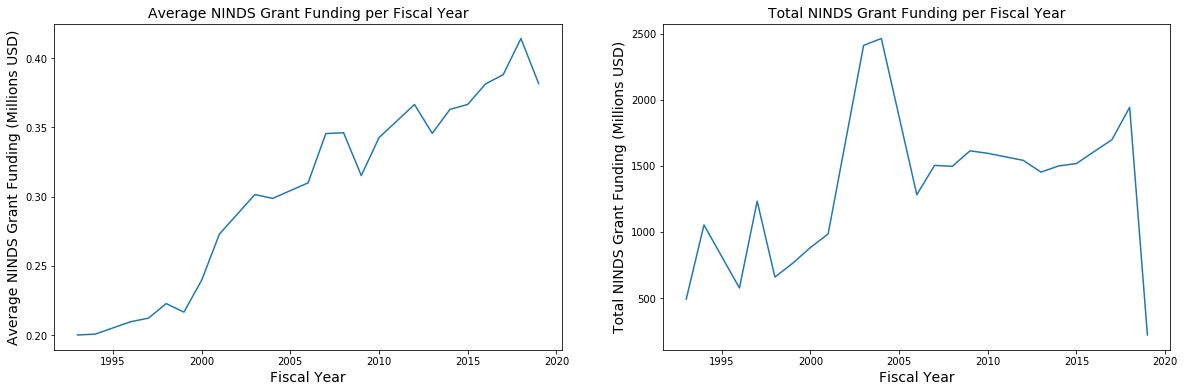

In [5]:
# Get average NINDS grant funding per fiscal year and total NINDS grant funding per fiscal year 
avg_ninds_grant_year = clean_ninds.groupby('ninds_fiscal_year')['ninds_fiscal_year_total_cost'].mean().reset_index()
total_ninds_grant_year = clean_ninds.groupby('ninds_fiscal_year')['ninds_fiscal_year_total_cost'].sum().reset_index()

# Plot average NINDS grant funding per fiscal year and total NINDS grant funding per fiscal year
f, ax = plt.subplots(1, 2, figsize=(20, 6))
ax1 = ax[0]
ax2 = ax[1]

sns.lineplot(avg_ninds_grant_year['ninds_fiscal_year'], avg_ninds_grant_year['ninds_fiscal_year_total_cost']/1000000, ax=ax1)
ax1.set_title('Average NINDS Grant Funding per Fiscal Year').set_fontsize(14)
ax1.set_xlabel('Fiscal Year').set_fontsize(14)
ax1.set_ylabel('Average NINDS Grant Funding (Millions USD)').set_fontsize(14)

sns.lineplot(total_ninds_grant_year['ninds_fiscal_year'], total_ninds_grant_year['ninds_fiscal_year_total_cost']/1000000, ax=ax2)
ax2.set_title('Total NINDS Grant Funding per Fiscal Year').set_fontsize(14)
ax2.set_xlabel('Fiscal Year').set_fontsize(14)
ax2.set_ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

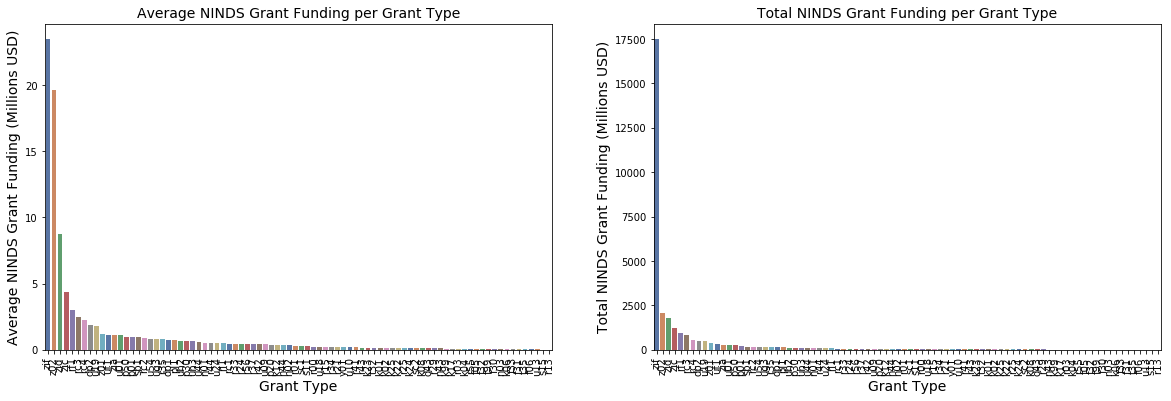

In [6]:
# Get average NINDS grant funding per grant type and total NINDS grant funding per grant type
avg_ninds_grant_type = clean_ninds.groupby('ninds_grant_type')['ninds_fiscal_year_total_cost'].mean().reset_index().sort_values(by="ninds_fiscal_year_total_cost", ascending=False)
total_ninds_grant_type = clean_ninds.groupby('ninds_grant_type')['ninds_fiscal_year_total_cost'].sum().reset_index().sort_values(by="ninds_fiscal_year_total_cost", ascending=False)

# Plot average NINDS grant funding per grant type and total NINDS grant funding per grant type
f, ax = plt.subplots(1, 2, figsize=(20, 6))
ax1 = ax[0]
ax2 = ax[1]

sns.barplot(avg_ninds_grant_type['ninds_grant_type'], avg_ninds_grant_type['ninds_fiscal_year_total_cost']/1000000, palette='deep', ax=ax1)
ax1.set_title('Average NINDS Grant Funding per Grant Type').set_fontsize(14)
ax1.set_xlabel('Grant Type').set_fontsize(14)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=10, rotation=90)
ax1.set_ylabel('Average NINDS Grant Funding (Millions USD)').set_fontsize(14)

sns.barplot(total_ninds_grant_type['ninds_grant_type'], total_ninds_grant_type['ninds_fiscal_year_total_cost']/1000000, palette='deep', ax=ax2)
ax2.set_title('Total NINDS Grant Funding per Grant Type').set_fontsize(14)
ax2.set_xlabel('Grant Type').set_fontsize(14)
ax2.set_xticklabels(ax1.get_xticklabels(), fontsize=10, rotation=90)
ax2.set_ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

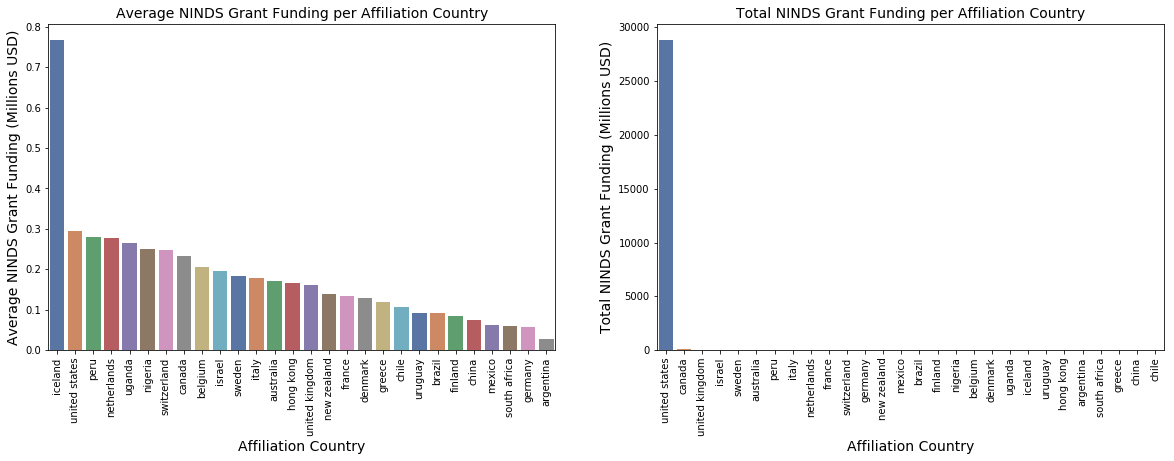

In [7]:
# Get average NINDS grant funding per affiliation country and total NINDS grant funding per affiliation country 
avg_ninds_grant_aff_country = clean_ninds.groupby('ninds_aff_country')['ninds_fiscal_year_total_cost'].mean().reset_index().sort_values(by="ninds_fiscal_year_total_cost", ascending=False)
total_ninds_grant_aff_country = clean_ninds.groupby('ninds_aff_country')['ninds_fiscal_year_total_cost'].sum().reset_index().sort_values(by="ninds_fiscal_year_total_cost", ascending=False)

# Plot average NINDS grant funding per affiliation country and total NINDS grant funding per affiliation country
f, ax = plt.subplots(1, 2, figsize=(20, 6))
ax1 = ax[0]
ax2 = ax[1]

sns.barplot(avg_ninds_grant_aff_country['ninds_aff_country'], avg_ninds_grant_aff_country['ninds_fiscal_year_total_cost']/1000000, palette='deep', ax=ax1)
ax1.set_title('Average NINDS Grant Funding per Affiliation Country').set_fontsize(14)
ax1.set_xlabel('Affiliation Country').set_fontsize(14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Average NINDS Grant Funding (Millions USD)').set_fontsize(14)

sns.barplot(total_ninds_grant_aff_country['ninds_aff_country'], total_ninds_grant_aff_country['ninds_fiscal_year_total_cost']/1000000, palette='deep', ax=ax2)
ax2.set_title('Total NINDS Grant Funding per Affiliation Country').set_fontsize(14)
ax2.set_xlabel('Affiliation Country').set_fontsize(14)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

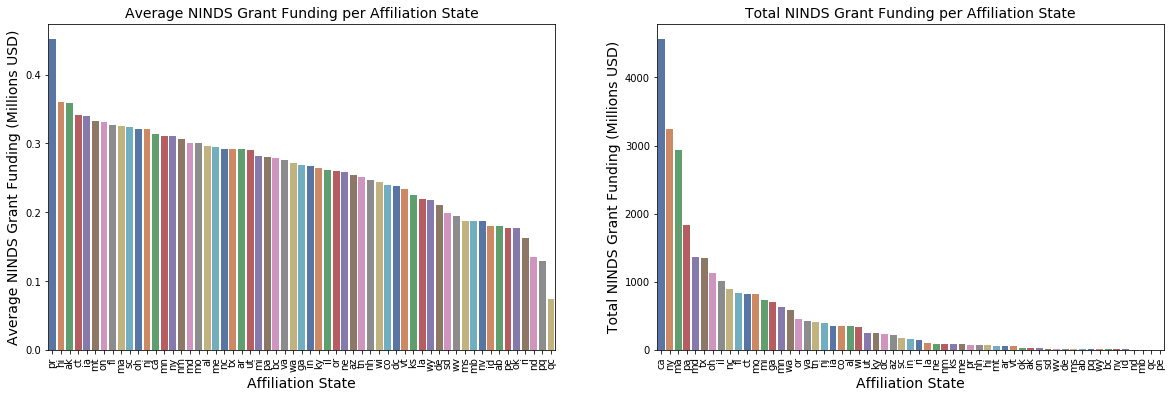

In [8]:
# Get average NINDS grant funding per affiliation state and total NINDS grant funding per affiliation state
avg_ninds_grant_aff_state = clean_ninds.groupby('ninds_aff_state')['ninds_fiscal_year_total_cost'].mean().reset_index().sort_values(by="ninds_fiscal_year_total_cost", ascending=False)
total_ninds_grant_aff_state = clean_ninds.groupby('ninds_aff_state')['ninds_fiscal_year_total_cost'].sum().reset_index().sort_values(by="ninds_fiscal_year_total_cost", ascending=False)

# Plot average NINDS grant funding per affiliation state and total NINDS grant funding per affiliation state
f, ax = plt.subplots(1, 2, figsize=(20, 6))
ax1 = ax[0]
ax2 = ax[1]

sns.barplot(avg_ninds_grant_aff_state['ninds_aff_state'], avg_ninds_grant_aff_state['ninds_fiscal_year_total_cost']/1000000, palette='deep', ax=ax1)
ax1.set_title('Average NINDS Grant Funding per Affiliation State').set_fontsize(14)
ax1.set_xlabel('Affiliation State').set_fontsize(14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Average NINDS Grant Funding (Millions USD)').set_fontsize(14)

sns.barplot(total_ninds_grant_aff_state['ninds_aff_state'], total_ninds_grant_aff_state['ninds_fiscal_year_total_cost']/1000000, palette='deep', ax=ax2)
ax2.set_title('Total NINDS Grant Funding per Affiliation State').set_fontsize(14)
ax2.set_xlabel('Affiliation State').set_fontsize(14)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

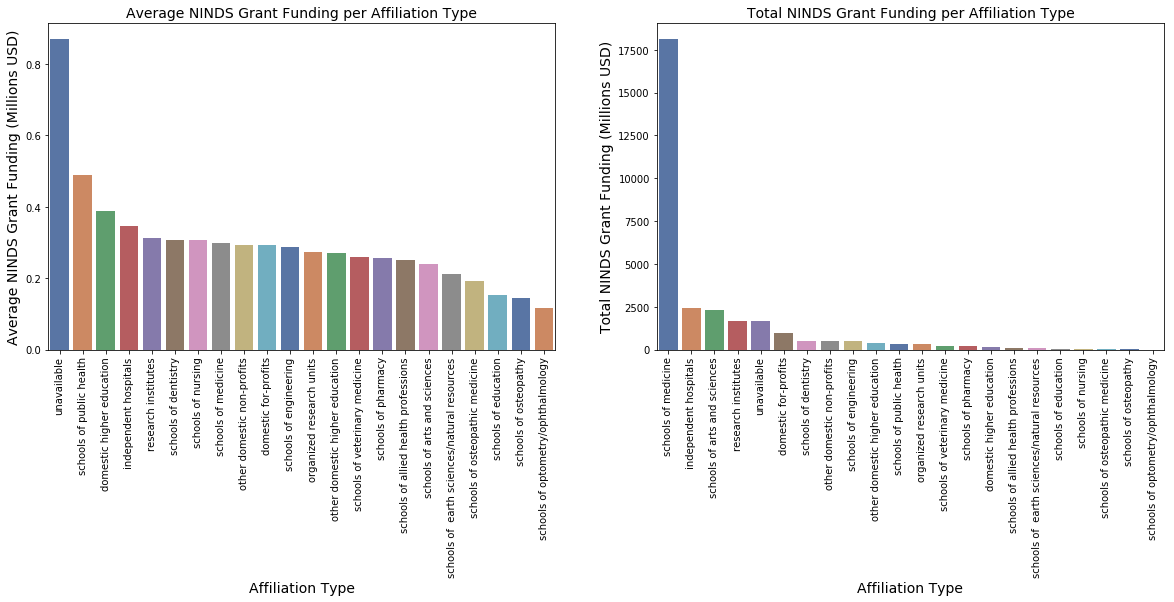

In [9]:
# Get average NINDS grant funding per affiliation type and total NINDS grant funding per affiliation type 
avg_ninds_grant_aff_type = clean_ninds.groupby('ninds_aff_type')['ninds_fiscal_year_total_cost'].mean().reset_index().sort_values(by="ninds_fiscal_year_total_cost", ascending=False)
total_ninds_grant_aff_type = clean_ninds.groupby('ninds_aff_type')['ninds_fiscal_year_total_cost'].sum().reset_index().sort_values(by="ninds_fiscal_year_total_cost", ascending=False)

# Plot average NINDS grant funding per affiliation type and total NINDS grant funding per affiliation type 
f, ax = plt.subplots(1, 2, figsize=(20, 6))
ax1 = ax[0]
ax2 = ax[1]

sns.barplot(avg_ninds_grant_aff_type['ninds_aff_type'], avg_ninds_grant_aff_type['ninds_fiscal_year_total_cost']/1000000, palette='deep', ax=ax1)
ax1.set_title('Average NINDS Grant Funding per Affiliation Type').set_fontsize(14)
ax1.set_xlabel('Affiliation Type').set_fontsize(14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Average NINDS Grant Funding (Millions USD)').set_fontsize(14)

sns.barplot(total_ninds_grant_aff_type['ninds_aff_type'], total_ninds_grant_aff_type['ninds_fiscal_year_total_cost']/1000000, palette='deep', ax=ax2)
ax2.set_title('Total NINDS Grant Funding per Affiliation Type').set_fontsize(14)
ax2.set_xlabel('Affiliation Type').set_fontsize(14)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

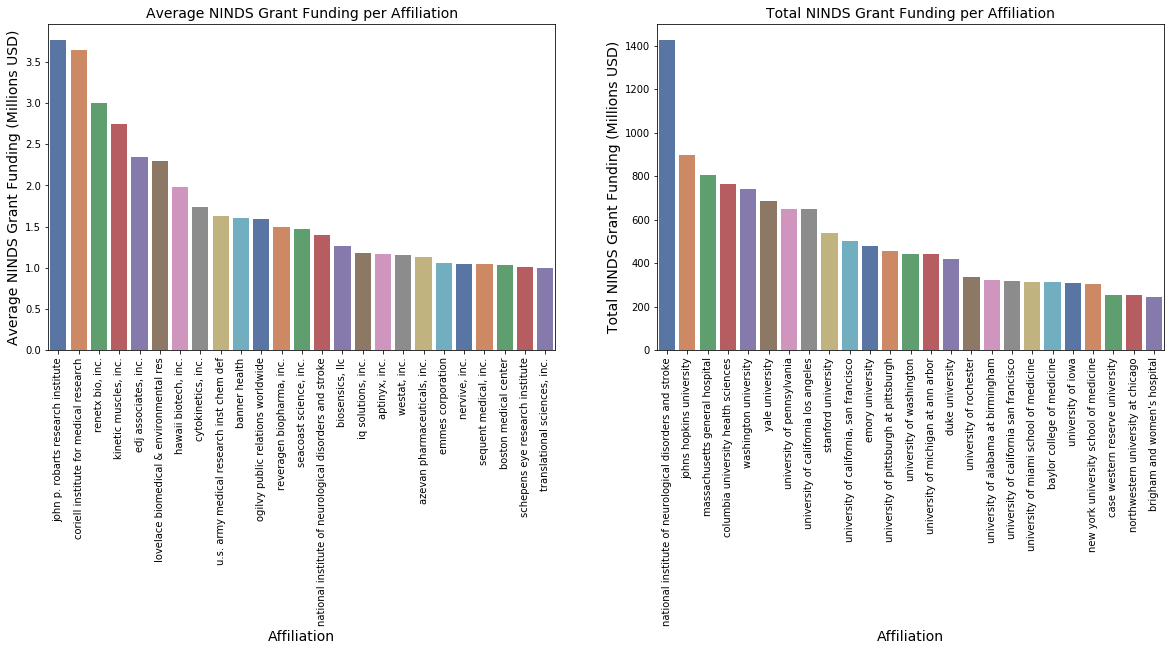

In [10]:
# Get top 25 affiliations in terms of average NINDS grant funding and total NINDS grant funding
avg_ninds_grant_aff = clean_ninds.groupby('ninds_aff_name')['ninds_fiscal_year_total_cost'].mean().reset_index().sort_values(by="ninds_fiscal_year_total_cost", ascending=False).iloc[0:25]
total_ninds_grant_aff = clean_ninds.groupby('ninds_aff_name')['ninds_fiscal_year_total_cost'].sum().reset_index().sort_values(by="ninds_fiscal_year_total_cost", ascending=False).iloc[0:25]

# Plot top 25 affiliations in terms of average NINDS grant funding and total NINDS grant funding
f, ax = plt.subplots(1, 2, figsize=(20, 6))
ax1 = ax[0]
ax2 = ax[1]

sns.barplot(avg_ninds_grant_aff['ninds_aff_name'], avg_ninds_grant_aff['ninds_fiscal_year_total_cost']/1000000, palette='deep', ax=ax1)
ax1.set_title('Average NINDS Grant Funding per Affiliation').set_fontsize(14)
ax1.set_xlabel('Affiliation').set_fontsize(14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Average NINDS Grant Funding (Millions USD)').set_fontsize(14)

sns.barplot(total_ninds_grant_aff['ninds_aff_name'], total_ninds_grant_aff['ninds_fiscal_year_total_cost']/1000000, palette='deep', ax=ax2)
ax2.set_title('Total NINDS Grant Funding per Affiliation').set_fontsize(14)
ax2.set_xlabel('Affiliation').set_fontsize(14)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

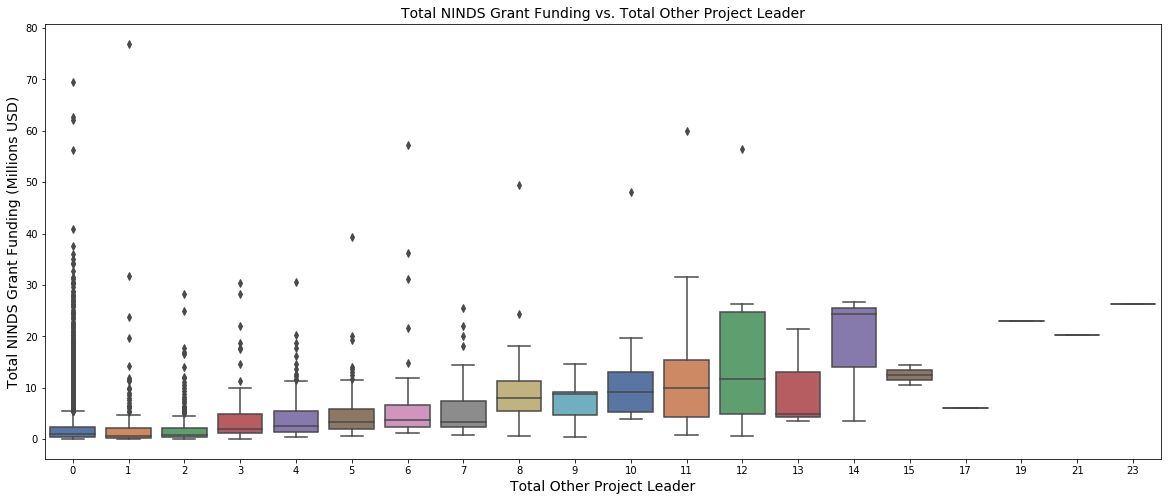

In [11]:
# Plot total NINDS grant funding vs. total other project leader
plt.figure(figsize=(20, 8))
sns.boxplot(model_reg['ninds_total_grant_other_project_leader'], model_reg['ninds_total_cost']/1000000, palette='deep')
plt.title('Total NINDS Grant Funding vs. Total Other Project Leader').set_fontsize(14)
plt.xlabel('Total Other Project Leader').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

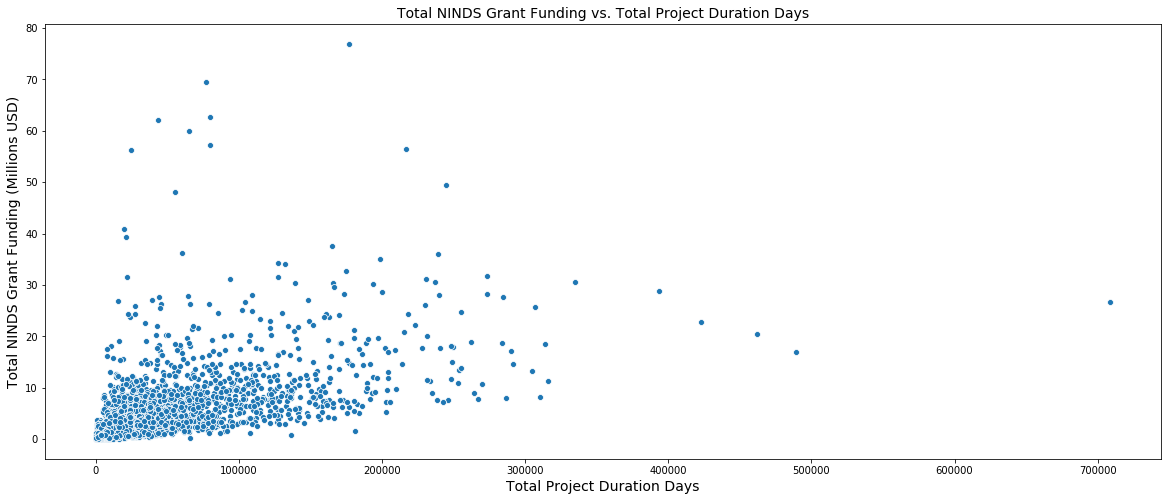

In [12]:
# Plot total NINDS grant funding vs. total project duration days
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['ninds_total_project_duration_days'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Total Project Duration Days').set_fontsize(14)
plt.xlabel('Total Project Duration Days').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

<a id="eaff"></a>
**Explore affiliations data**

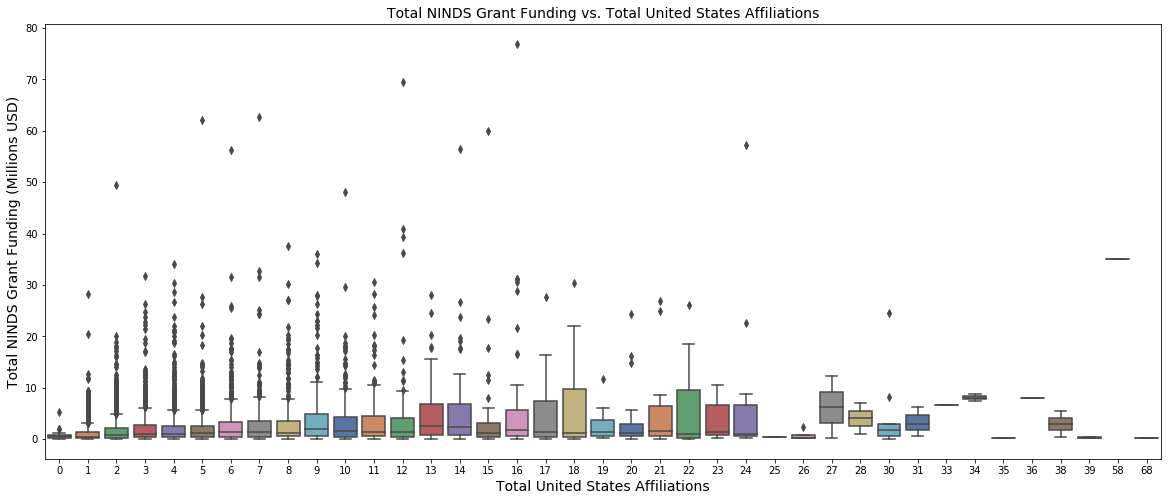

In [13]:
# Plot total NINDS grant funding vs. total united states affiliations 
plt.figure(figsize=(20, 8))
sns.boxplot(model_reg['aff_total_united_states'], model_reg['ninds_total_cost']/1000000, palette='deep')
plt.title('Total NINDS Grant Funding vs. Total United States Affiliations').set_fontsize(14)
plt.xlabel('Total United States Affiliations').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

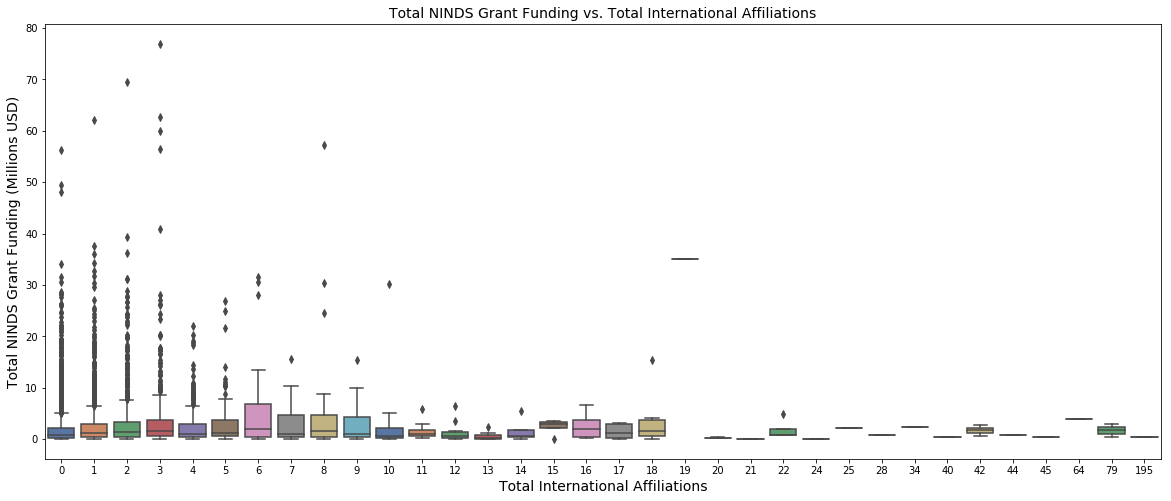

In [14]:
# Plot total NINDS grant funding vs. total international affiliations
plt.figure(figsize=(20, 8))
sns.boxplot(model_reg['aff_total_international'], model_reg['ninds_total_cost']/1000000, palette='deep')
plt.title('Total NINDS Grant Funding vs. Total International Affiliations').set_fontsize(14)
plt.xlabel('Total International Affiliations').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

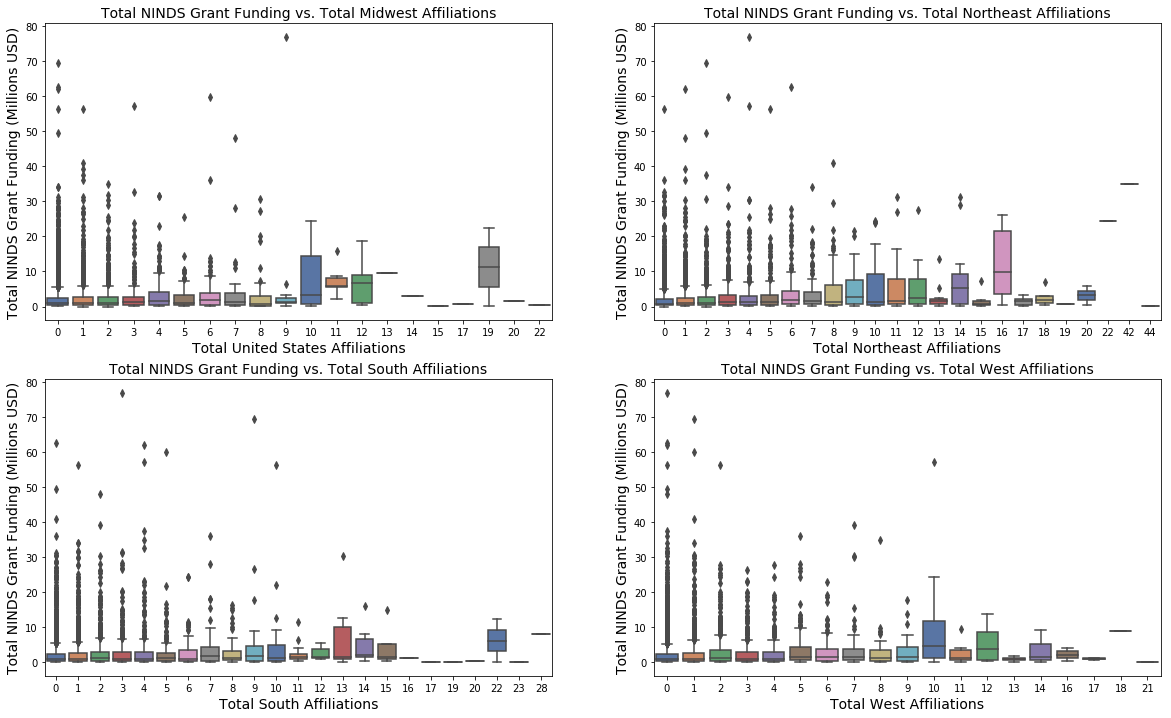

In [15]:
# Plot total NINDS grant funding vs. total midwest affiliations, total NINDS grant funding vs. total northeast affiliations, total NINDS grant funding vs. total south affiliations, and total NINDS grant funding vs. total west affiliations 
f, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]

sns.boxplot(model_reg['aff_total_midwest'], model_reg['ninds_total_cost']/1000000, palette='deep', ax=ax1)
ax1.set_title('Total NINDS Grant Funding vs. Total Midwest Affiliations').set_fontsize(14)
ax1.set_xlabel('Total United States Affiliations').set_fontsize(14)
ax1.set_ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

sns.boxplot(model_reg['aff_total_northeast'], model_reg['ninds_total_cost']/1000000, palette='deep', ax=ax2)
ax2.set_title('Total NINDS Grant Funding vs. Total Northeast Affiliations').set_fontsize(14)
ax2.set_xlabel('Total Northeast Affiliations').set_fontsize(14)
ax2.set_ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

sns.boxplot(model_reg['aff_total_south'], model_reg['ninds_total_cost']/1000000, palette='deep', ax=ax3)
ax3.set_title('Total NINDS Grant Funding vs. Total South Affiliations').set_fontsize(14)
ax3.set_xlabel('Total South Affiliations').set_fontsize(14)
ax3.set_ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

sns.boxplot(model_reg['aff_total_west'], model_reg['ninds_total_cost']/1000000, palette='deep', ax=ax4)
ax4.set_title('Total NINDS Grant Funding vs. Total West Affiliations').set_fontsize(14)
ax4.set_xlabel('Total West Affiliations').set_fontsize(14)
ax4.set_ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

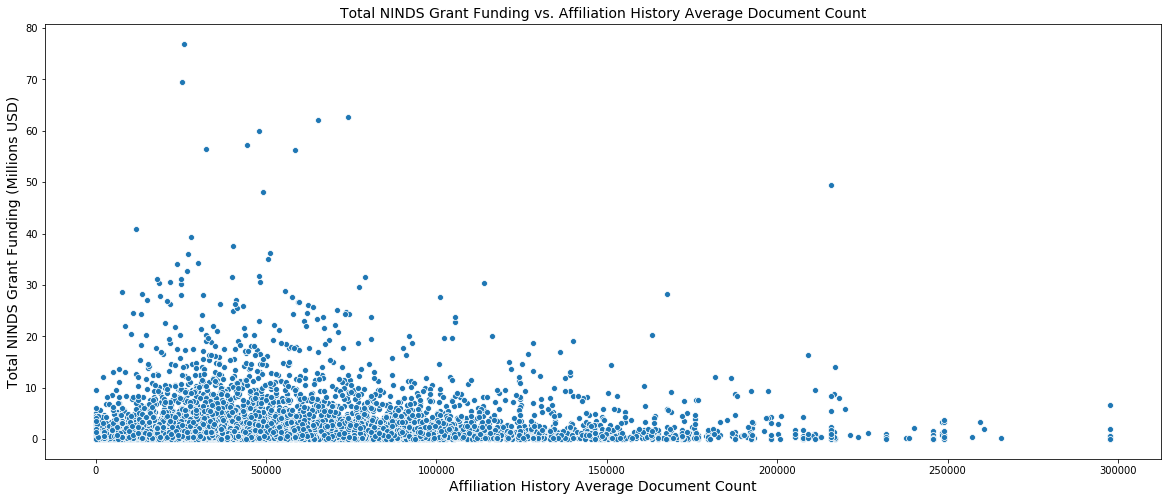

In [16]:
# Plot total NINDS grant funding vs. affiliation history average document count 
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['aff_avg_document_count'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Affiliation History Average Document Count').set_fontsize(14)
plt.xlabel('Affiliation History Average Document Count').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

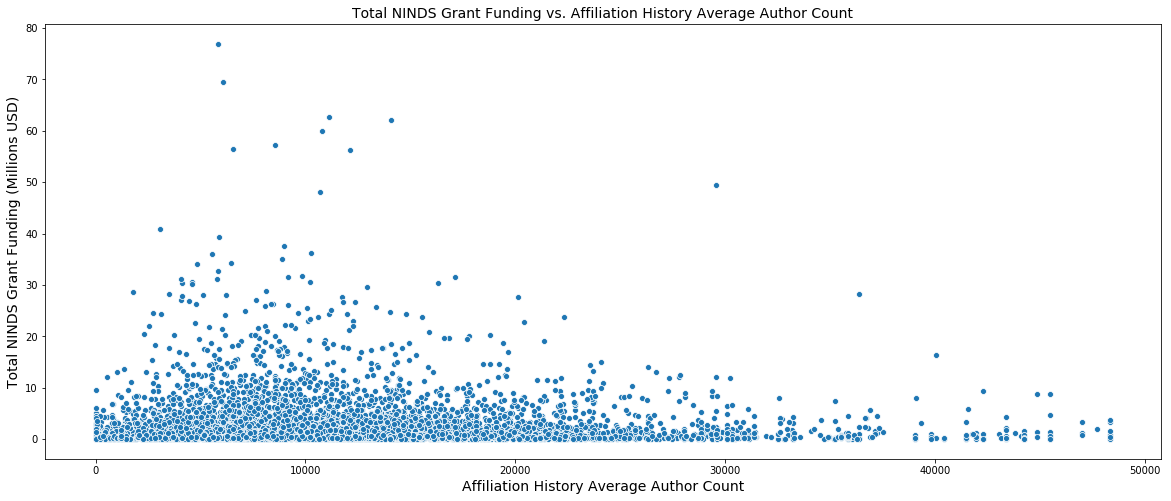

In [17]:
# Plot total NINDS grant funding vs. affiliation history average author count
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['aff_avg_author_count'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Affiliation History Average Author Count').set_fontsize(14)
plt.xlabel('Affiliation History Average Author Count').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

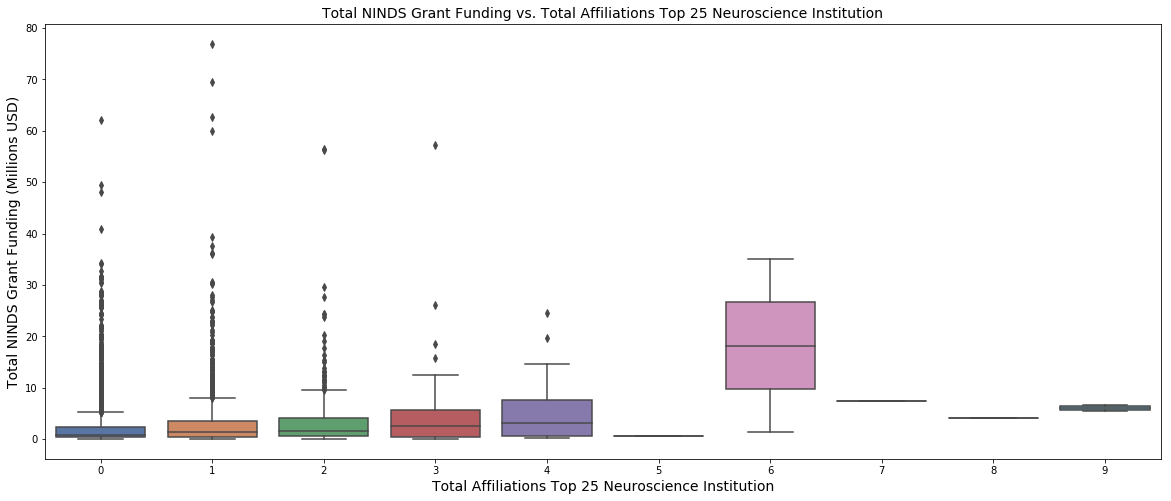

In [18]:
# Plot total NINDS grant funding vs. total affiliations top 25 neuroscience institution
plt.figure(figsize=(20, 8))
sns.boxplot(model_reg['aff_total_top_25_neuro'], model_reg['ninds_total_cost']/1000000, palette='deep')
plt.title('Total NINDS Grant Funding vs. Total Affiliations Top 25 Neuroscience Institution').set_fontsize(14)
plt.xlabel('Total Affiliations Top 25 Neuroscience Institution').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

<a id="ecoauth"></a>
**Explore coauthors data**

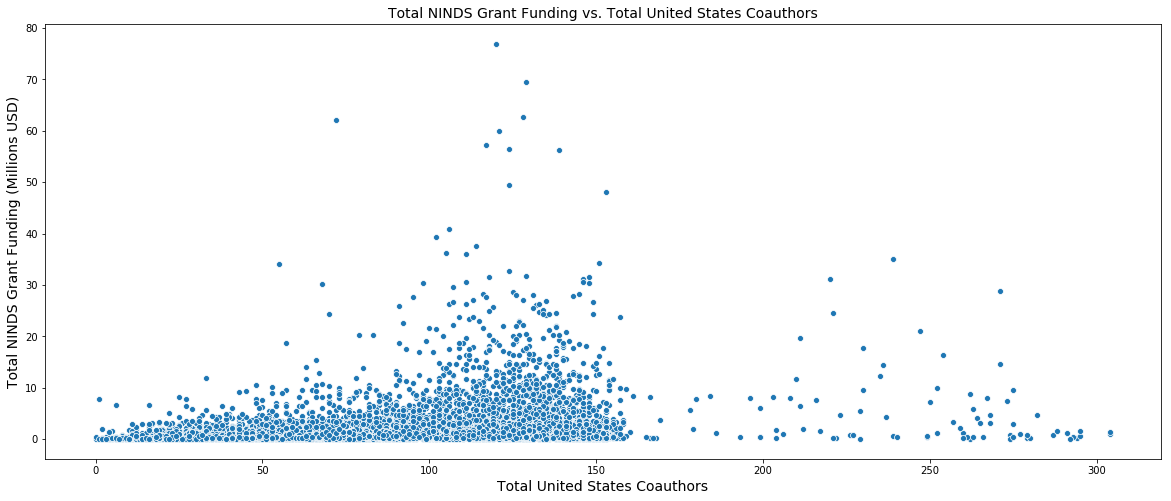

In [19]:
# Plot total NINDS grant funding vs. total united states coauthors 
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['coauth_total_aff_united_states'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Total United States Coauthors').set_fontsize(14)
plt.xlabel('Total United States Coauthors').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

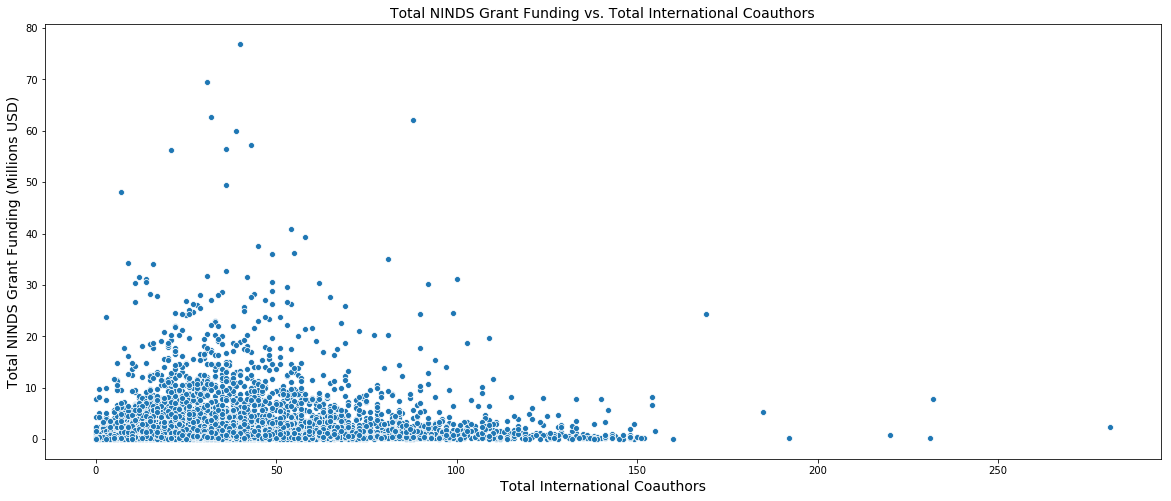

In [20]:
# Plot total NINDS grant funding vs. total international coauthors
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['coauth_total_aff_international'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Total International Coauthors').set_fontsize(14)
plt.xlabel('Total International Coauthors').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

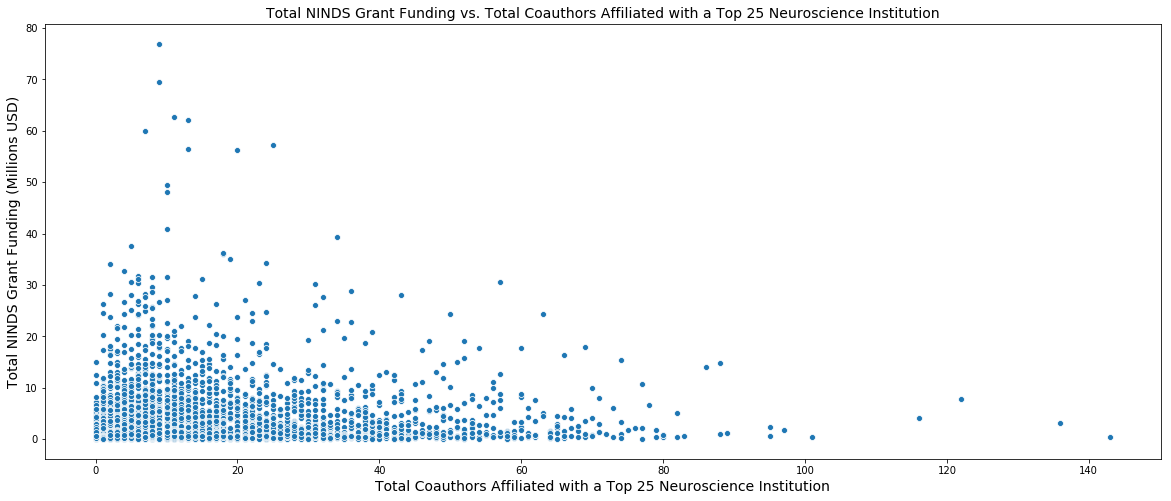

In [21]:
# Plot total NINDS grant funding vs. total coauthors affiliated with a top 25 neuroscience institution
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['coauth_total_aff_top_25_neuro'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Total Coauthors Affiliated with a Top 25 Neuroscience Institution').set_fontsize(14)
plt.xlabel('Total Coauthors Affiliated with a Top 25 Neuroscience Institution').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

<a id="ejour"></a>
**Explore journals data**

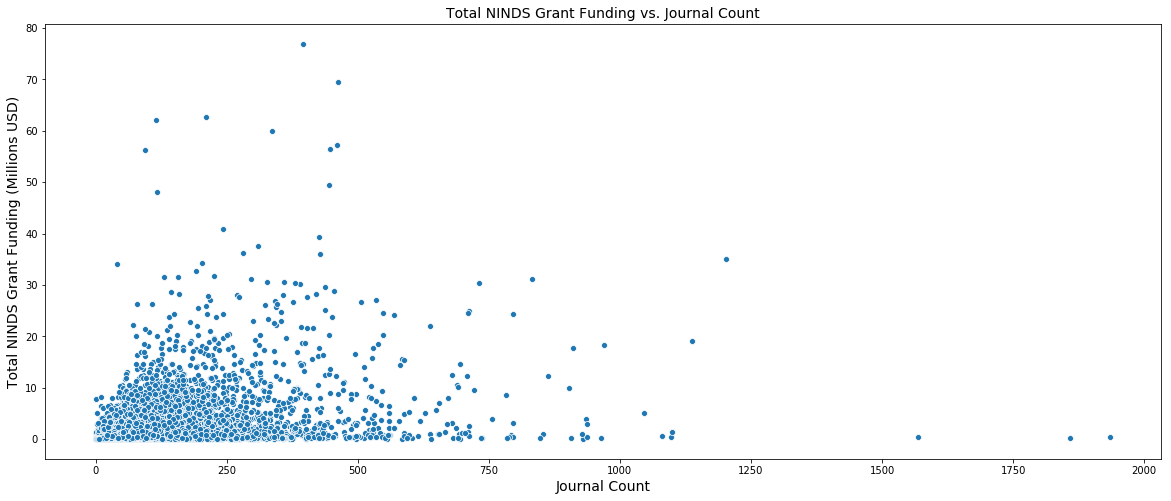

In [22]:
# Plot total NINDS grant funding vs. journal count
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['jour_total_pub_type_journal'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Journal Count').set_fontsize(14)
plt.xlabel('Journal Count').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

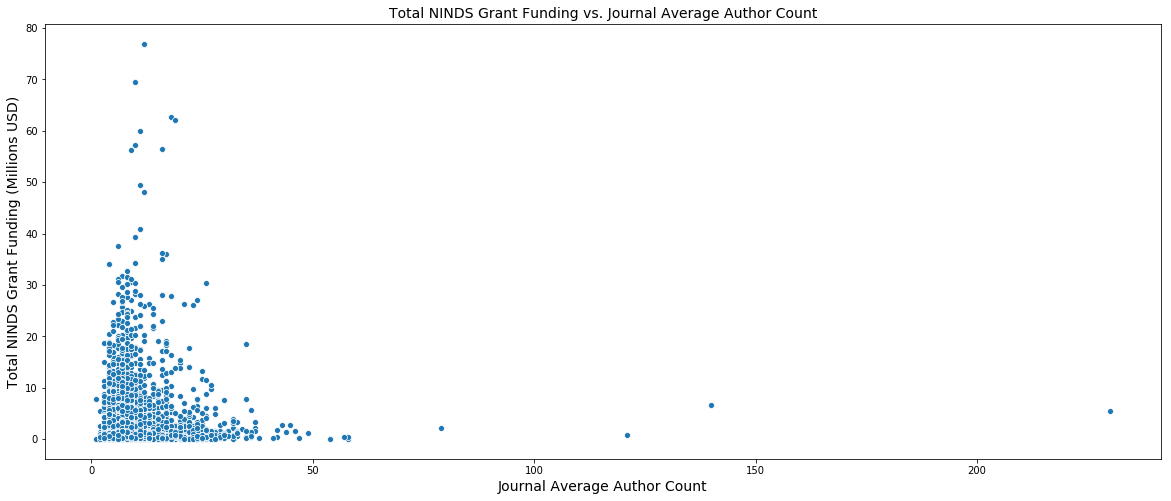

In [23]:
# Plot total NINDS grant funding vs. journal average author count
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['jour_avg_author_count'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Journal Average Author Count').set_fontsize(14)
plt.xlabel('Journal Average Author Count').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

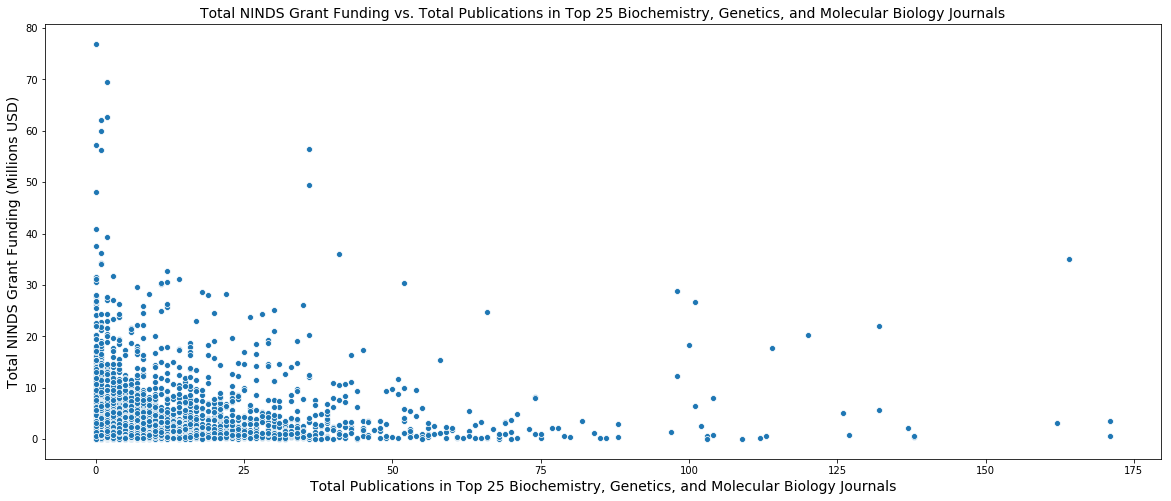

In [24]:
# Plot total NINDS grant funding vs. total publications in top 25 journals for biochemistry, genetics and molecular biology based on h-index
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['jour_total_pub_top_25_biochem_gen_molec'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Total Publications in Top 25 Biochemistry, Genetics, and Molecular Biology Journals').set_fontsize(14)
plt.xlabel('Total Publications in Top 25 Biochemistry, Genetics, and Molecular Biology Journals').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

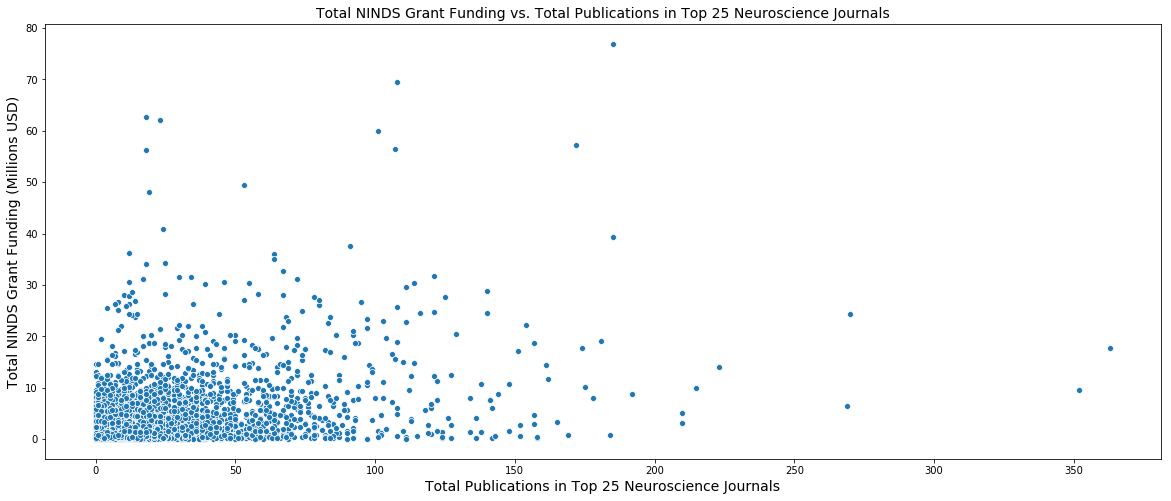

In [25]:
# Plot total NINDS grant funding vs. total publications in top 25 journals for neuroscience based on h-index
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['jour_total_pub_top_25_neuro'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Total Publications in Top 25 Neuroscience Journals').set_fontsize(14)
plt.xlabel('Total Publications in Top 25 Neuroscience Journals').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

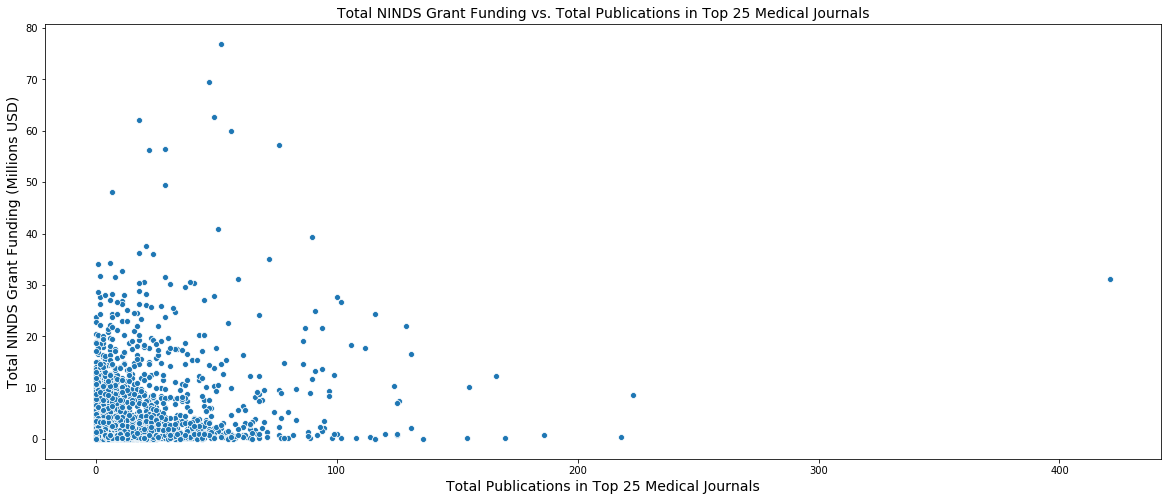

In [26]:
# Plot total NINDS grant funding vs. total publications in top 25 journals for medicine based on h-index
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['jour_total_pub_top_25_med'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Total Publications in Top 25 Medical Journals').set_fontsize(14)
plt.xlabel('Total Publications in Top 25 Medical Journals').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

<a id="escopus"></a>
**Explore scopus data**

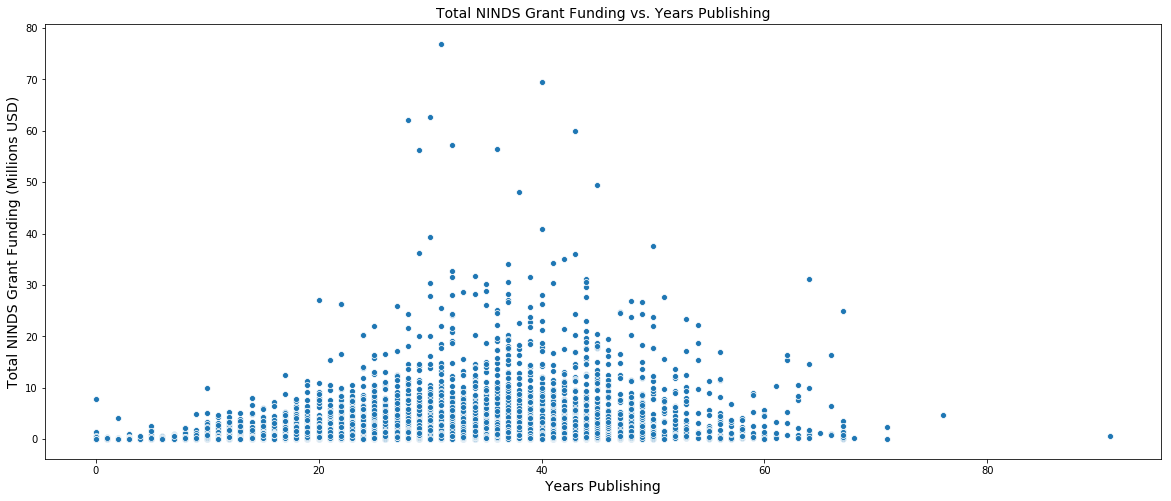

In [27]:
# Plot total NINDS grant funding vs. years publishing
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['scopus_pub_range_years'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Years Publishing').set_fontsize(14)
plt.xlabel('Years Publishing').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

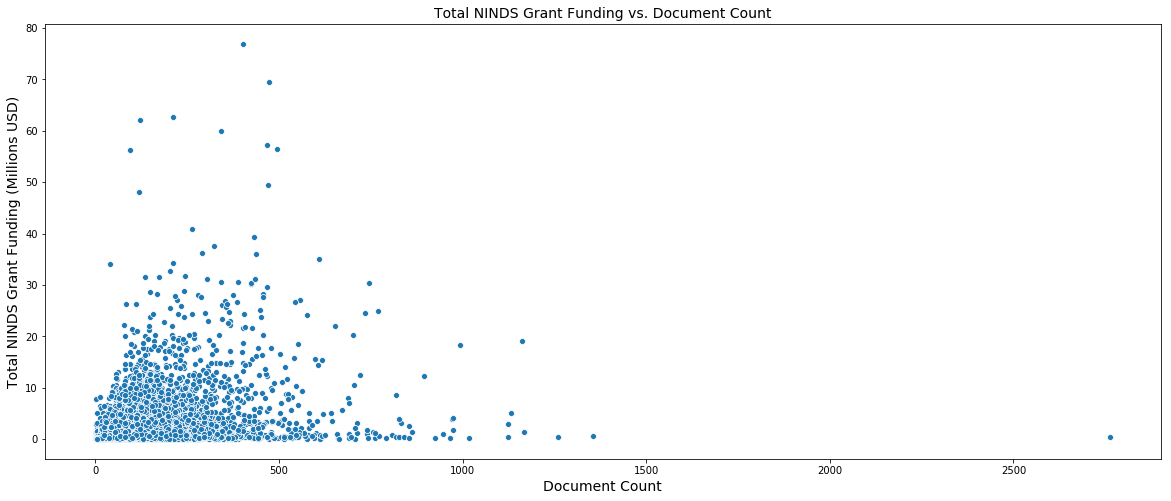

In [28]:
# Plot total NINDS grant funding vs. document count
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['scopus_document_count'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Document Count').set_fontsize(14)
plt.xlabel('Document Count').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

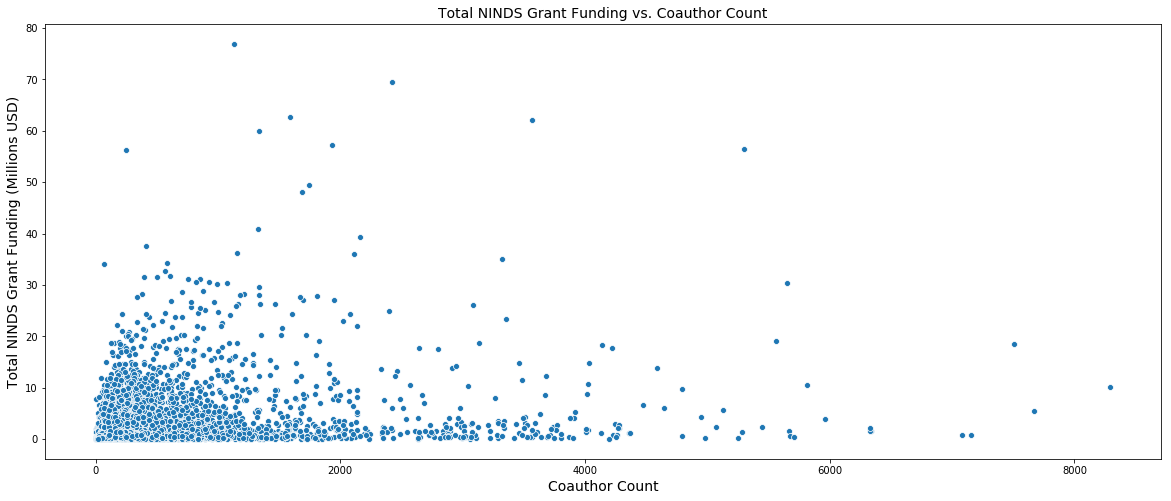

In [29]:
# Plot total NINDS grant funding vs. coauthor count
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['scopus_coauthor_count'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Coauthor Count').set_fontsize(14)
plt.xlabel('Coauthor Count').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

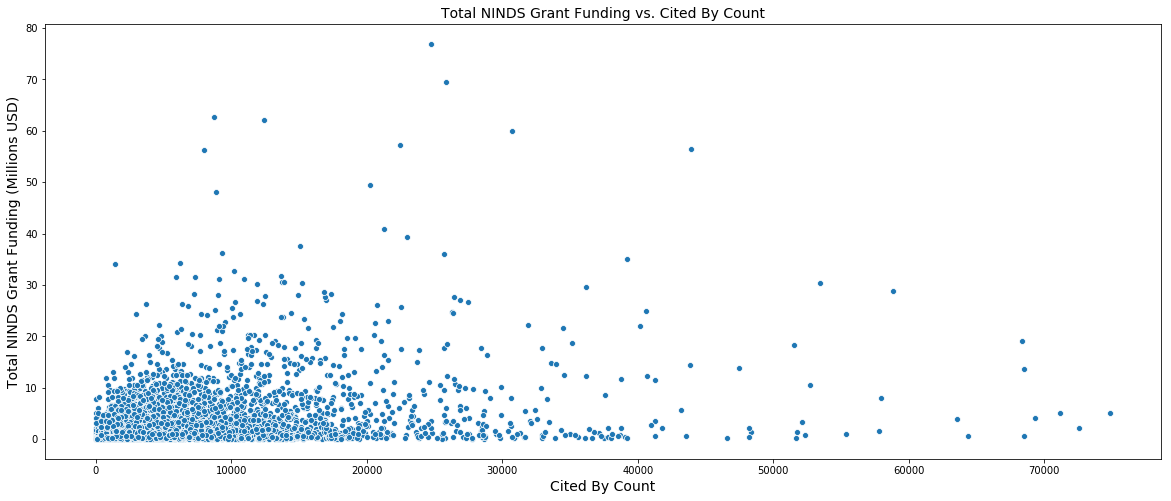

In [30]:
# Plot total NINDS grant funding vs. cited by count 
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['scopus_cited_by_count'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Cited By Count').set_fontsize(14)
plt.xlabel('Cited By Count').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

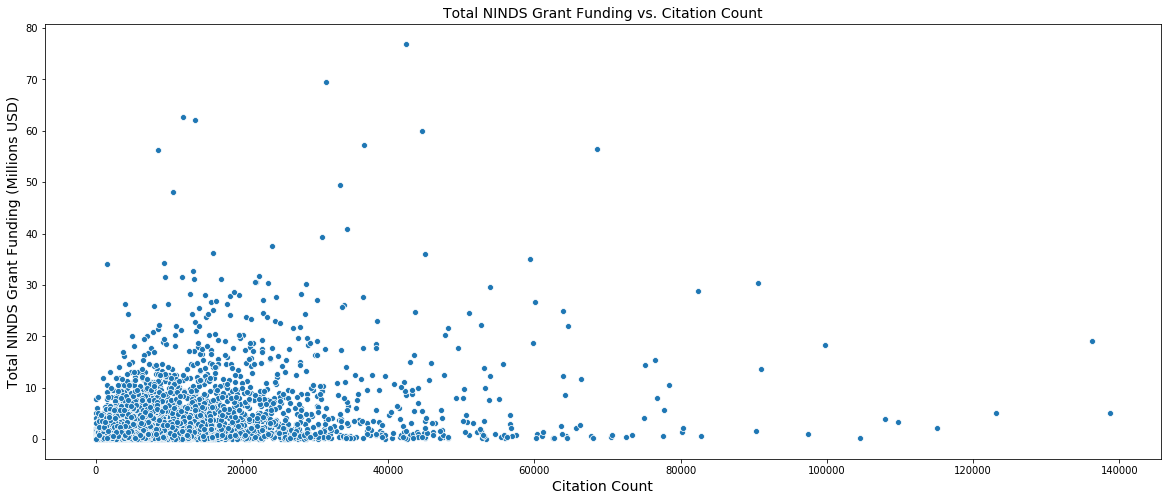

In [31]:
# Plot total NINDS grant funding vs. citation count
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['scopus_citation_count'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. Citation Count').set_fontsize(14)
plt.xlabel('Citation Count').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

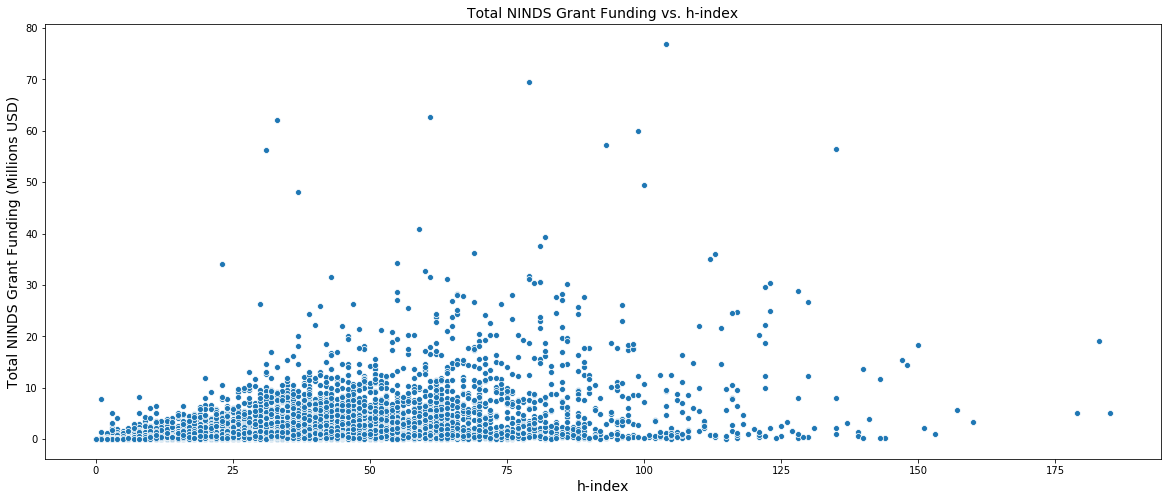

In [32]:
# Plot total NINDS grant funding vs. h-index
plt.figure(figsize=(20, 8))
sns.scatterplot(model_reg['scopus_h_index'], model_reg['ninds_total_cost']/1000000)
plt.title('Total NINDS Grant Funding vs. h-index').set_fontsize(14)
plt.xlabel('h-index').set_fontsize(14)
plt.ylabel('Total NINDS Grant Funding (Millions USD)').set_fontsize(14)

<a id="fim"></a>
## Feature Importance & Models
We used model_data_regression with lasso regression and random forest regressor and model_data_classification with random forest classifier to obtain important features in neuroscience researchers' NINDS grant funding. 

In [33]:
# Get data 
df_reg = pd.read_csv('data/model_data_regression.csv', index_col=0)
df_class = pd.read_csv('data/model_data_classification.csv', index_col=0)

In [34]:
# Get features and target for regression and classification
target = 'ninds_total_cost'

X_reg = df_reg.drop([target], axis=1)
features_reg = X_reg.columns
y_reg = df_reg[target]

X_class = df_class.drop([target], axis=1)
features_class = X_class.columns
y_class = df_class[target]

<a id="lr"></a>
**Lasso regression**

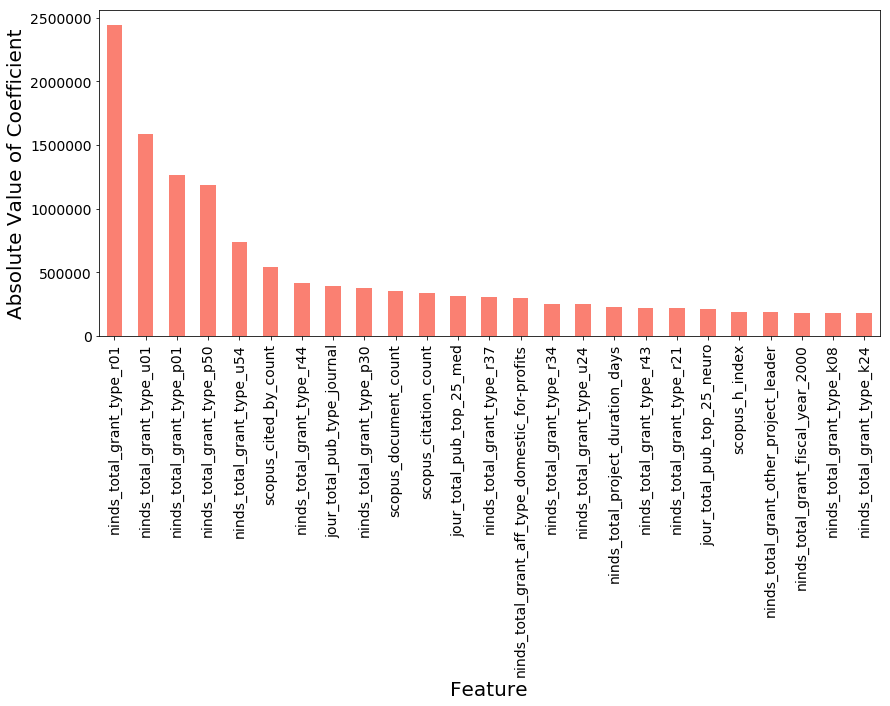

In [35]:
# Lasso regression
pipe_lasso = Pipeline([('StandardScaler', StandardScaler()), ('LassoRegression', Lasso(random_state=0))])

pipe_lasso.fit(X_reg, y_reg)

features_lasso = X_reg.columns
coefs_lasso = pipe_lasso.named_steps['LassoRegression'].coef_
important_features_lasso = []
for i in range(0, len(features_lasso)):
    important_features_lasso.append([features_lasso[i], np.absolute(coefs_lasso[i])])

important_features_lasso = sorted(important_features_lasso, key=lambda x: x[1], reverse=True)
important_features_lasso = pd.DataFrame(important_features_lasso)[0:25]

ax=plt.subplot()
important_features_lasso.plot(x=0, y=1, kind='bar', legend=False, figsize=(14,6), color='salmon', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Feature', fontsize=20)
ax.set_ylabel('Absolute Value of Coefficient', fontsize=20)
plt.show()

In [36]:
# Hyperparameter tune lasso regression
clfs = {'lr': Lasso(random_state=0)}

pipe_clfs = {}
for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

param_grids = {}
param_grid = [{'clf__alpha': [10 ** i for i in range(-5, 1)]}]
param_grids['lr'] = param_grid

best_score_param_estimators = []
for name in pipe_clfs.keys():
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='neg_mean_squared_error',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=0))
    gs = gs.fit(X_reg, y_reg)
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)
for best_score_param_estimator in best_score_param_estimators:
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[-13063306498151.744, {'clf__alpha': 1}, <class 'sklearn.linear_model.coordinate_descent.Lasso'>]



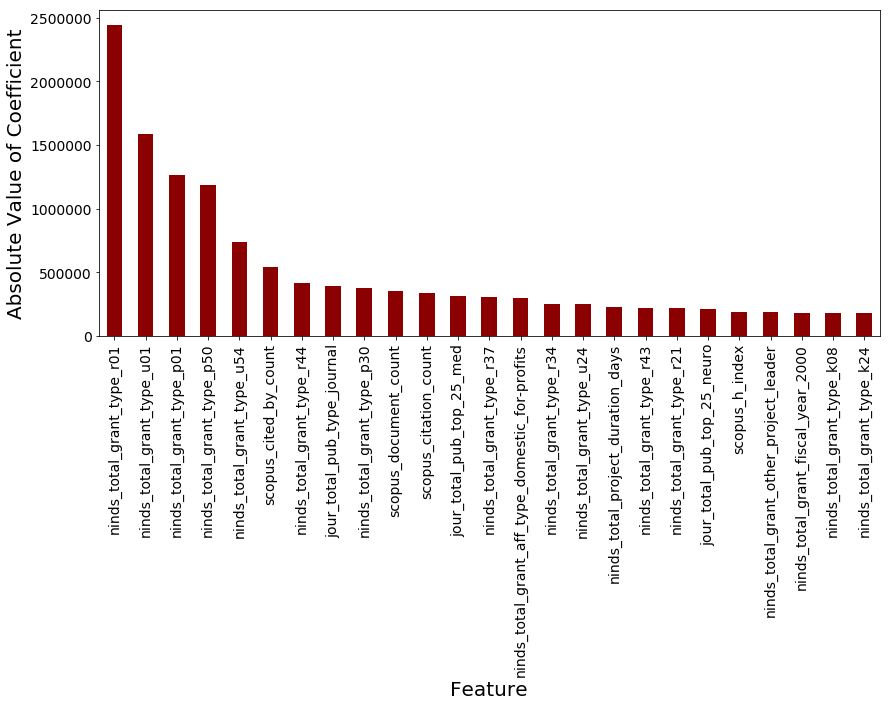

In [37]:
# Plot feature importance based on hyperparameter tuned lasso regression
pipe_hyp_lasso = Pipeline([('StandardScaler', StandardScaler()), ('LassoRegression', Lasso(alpha=1, random_state=0))])

pipe_hyp_lasso.fit(X_reg, y_reg)

pipe_hyp_lasso.fit(X_reg, y_reg)

features_hyp_lasso = X_reg.columns
coefs_hyp_lasso = pipe_hyp_lasso.named_steps['LassoRegression'].coef_
important_features_hyp_lasso = []
for i in range(0, len(features_hyp_lasso)):
    important_features_hyp_lasso.append([features_hyp_lasso[i], np.absolute(coefs_hyp_lasso[i])])

important_features_hyp_lasso = sorted(important_features_hyp_lasso, key=lambda x: x[1], reverse=True)
important_features_hyp_lasso = pd.DataFrame(important_features_hyp_lasso)[0:25]

ax=plt.subplot()
important_features_hyp_lasso.plot(x=0, y=1, kind='bar', legend=False, figsize=(14,6), color='darkred', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Feature', fontsize=20)
ax.set_ylabel('Absolute Value of Coefficient', fontsize=20)
plt.show()

<a id="rfr"></a>
**Random forest regressor**

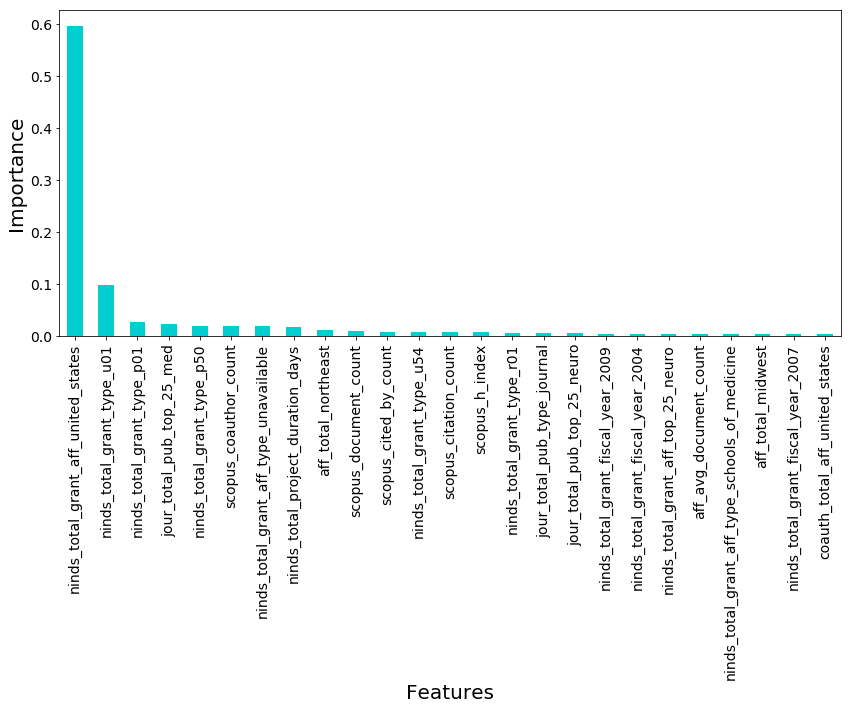

In [38]:
# Random forest regressor
pipe_rfr = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestRegressor', RandomForestRegressor(random_state=0))])

pipe_rfr.fit(X_reg, y_reg)

important_features_rfr = pd.Series(pipe_rfr.named_steps['RandomForestRegressor'].feature_importances_, features_reg)
important_features_rfr = important_features_rfr.sort_values(ascending=False)[0:25]

ax=plt.subplot()
important_features_rfr.plot(x='Features', y='Importance', kind='bar', figsize=(14,6), color='darkturquoise', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Importance', fontsize=20)
plt.show()

In [39]:
# Hyperparameter tune random forest regressor
clfs = {'rfr': RandomForestRegressor(random_state=0)}

pipe_clfs = {}
for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

param_grids = {}
param_grid = [{'clf__n_estimators': [2, 10, 30],
               'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]
param_grids['rfr'] = param_grid

best_score_param_estimators = []
for name in pipe_clfs.keys():
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='neg_mean_squared_error',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=0))
    gs = gs.fit(X_reg, y_reg)
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)
for best_score_param_estimator in best_score_param_estimators:
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[-20796360639708.797, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 10}, <class 'sklearn.ensemble.forest.RandomForestRegressor'>]



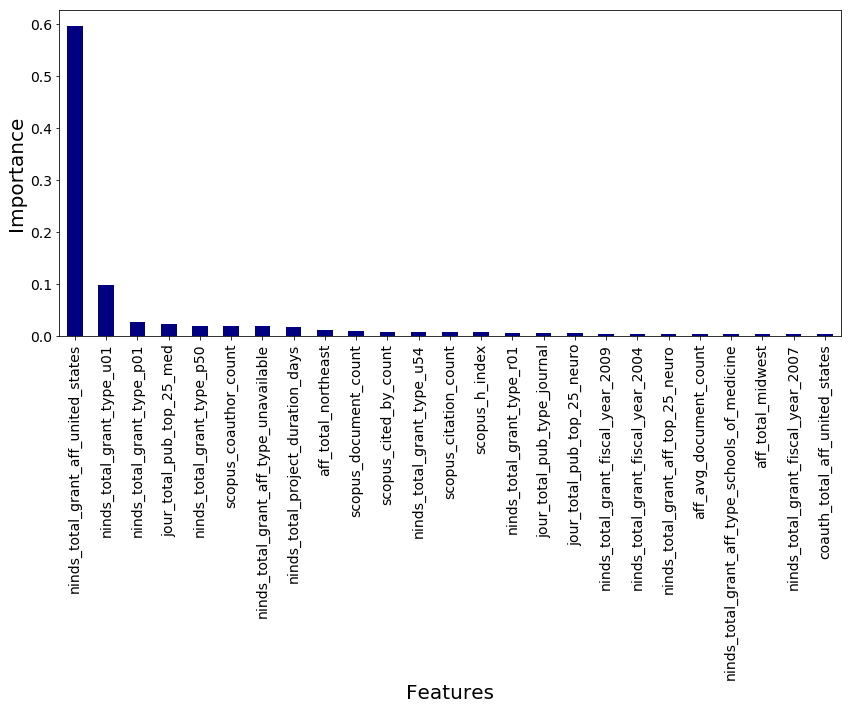

In [40]:
# Plot feature importance based on hyperparameter tuned random forest regressor
pipe_hyp_rfr = Pipeline([('StandardScaler', StandardScaler()), 
                         ('RandomForestRegressor', RandomForestRegressor(min_samples_leaf=1, 
                                                                         min_samples_split=2, 
                                                                         n_estimators=10,
                                                                         random_state=0))])

pipe_hyp_rfr.fit(X_reg, y_reg)

important_features_hyp_rfr = pd.Series(pipe_hyp_rfr.named_steps['RandomForestRegressor'].feature_importances_, features_reg)
important_features_hyp_rfr = important_features_hyp_rfr.sort_values(ascending=False)[0:25]

ax=plt.subplot()
important_features_hyp_rfr.plot(x='Feature', y='Importance', kind='bar', figsize=(14,6), color='navy', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Importance', fontsize=20)
plt.show()

<a id="rfc"></a>
**Random forest classifier**

In [41]:
# Random over sampler
ros = RandomOverSampler(random_state=0)
X_class, y_class = ros.fit_sample(X_class, y_class)

pd.DataFrame(data=y_class, columns=[target])[target].value_counts()

3.0    7172
5.0    7172
4.0    7172
2.0    7172
1.0    7172
Name: ninds_total_cost, dtype: int64

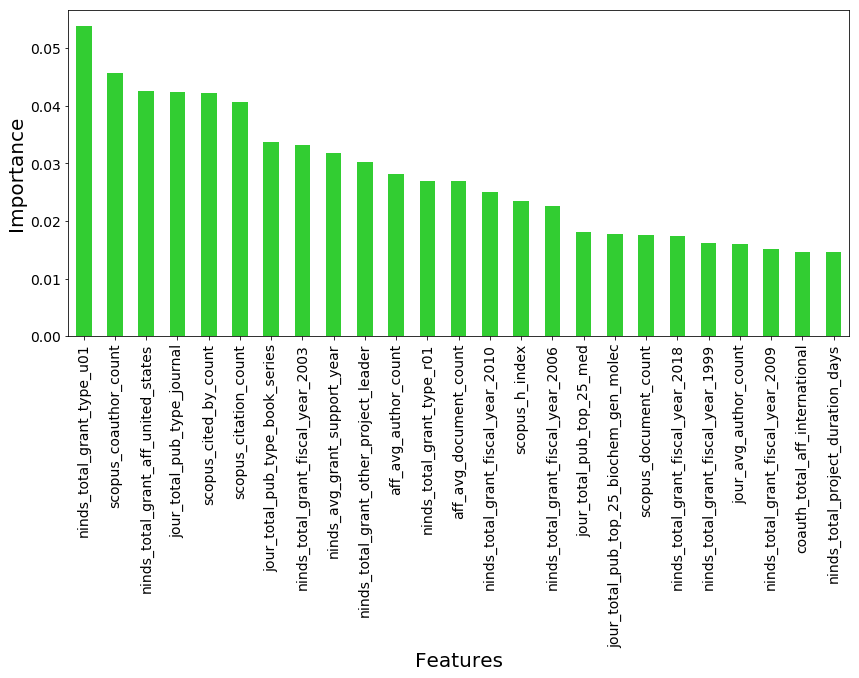

In [42]:
# Random forest classifier
pipe_rfc = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestClassifier', RandomForestClassifier(random_state=0))])

pipe_rfc.fit(X_class, y_class)

important_features_rfc = pd.Series(pipe_rfc.named_steps['RandomForestClassifier'].feature_importances_, features_class)
important_features_rfc = important_features_rfc.sort_values(ascending=False)[0:25]

ax=plt.subplot()
important_features_rfc.plot(x='Feature', y='Importance', kind='bar', figsize=(14,6), color='limegreen', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Importance', fontsize=20)
plt.show()

In [43]:
# Hyperparameter tune random forest classifier
clfs = {'rfc': RandomForestClassifier(random_state=0)}

pipe_clfs = {}
for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

param_grids = {}
param_grid = [{'clf__n_estimators': [2, 10, 30],
               'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]
param_grids['rfc'] = param_grid

best_score_param_estimators = []
for name in pipe_clfs.keys():
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=0))
    gs = gs.fit(X_class, y_class)
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)
for best_score_param_estimator in best_score_param_estimators:
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[0.9996932515337423, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 30}, <class 'sklearn.ensemble.forest.RandomForestClassifier'>]



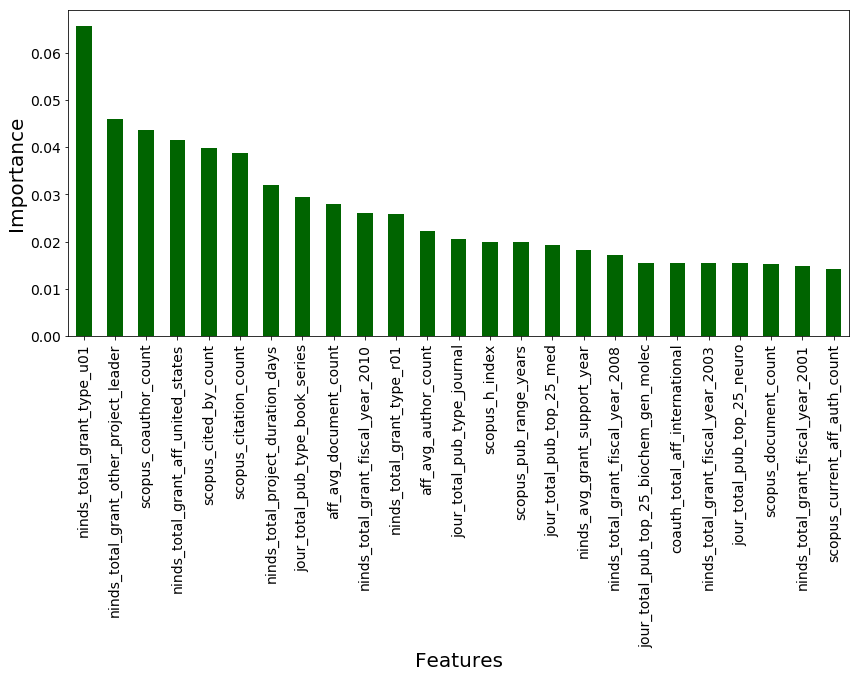

In [44]:
# Plot feature importance based on hyperparameter tuned random forest classifier
pipe_hyp_rfc = Pipeline([('StandardScaler', StandardScaler()), 
                         ('RandomForestClassifier', RandomForestClassifier(min_samples_leaf=1, 
                                                                           min_samples_split=2, 
                                                                           n_estimators=30,
                                                                           random_state=0))])

pipe_hyp_rfc.fit(X_class, y_class)

important_features_hyp_rfc = pd.Series(pipe_hyp_rfc.named_steps['RandomForestClassifier'].feature_importances_, features_class)
important_features_hyp_rfc = important_features_hyp_rfc.sort_values(ascending=False)[0:25]

ax=plt.subplot()
important_features_hyp_rfc.plot(x='Feature', y='Importance', kind='bar', figsize=(14,6), color='darkgreen', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Importance', fontsize=20)
plt.show()

<a id="cif"></a>
**Common important features**

In [45]:
# Create important features columns
important_features_lasso['important_features'] = important_features_lasso[0]
important_features_hyp_lasso['important_features'] = important_features_hyp_lasso[0]
important_features_rfr = important_features_rfr.reset_index()
important_features_rfr['important_features'] = important_features_rfr['index']
important_features_hyp_rfr = important_features_hyp_rfr.reset_index()
important_features_hyp_rfr['important_features'] = important_features_hyp_rfr['index']
important_features_rfc = important_features_rfc.reset_index()
important_features_rfc['important_features'] = important_features_rfc['index']
important_features_hyp_rfc = important_features_hyp_rfc.reset_index()
important_features_hyp_rfc['important_features'] = important_features_hyp_rfc['index']

# Find common important features 
common_important_features = pd.merge(important_features_lasso, important_features_hyp_lasso, on='important_features', how='inner')
common_important_features = pd.merge(common_important_features, important_features_rfr, on='important_features', how='inner')
common_important_features = pd.merge(common_important_features, important_features_hyp_rfr, on='important_features', how='inner')
common_important_features = pd.merge(common_important_features, important_features_rfc, on='important_features', how='inner')
common_important_features = pd.merge(common_important_features, important_features_hyp_rfc, on='important_features', how='inner')
common_important_features['important_features']

0           ninds_total_grant_type_r01
1           ninds_total_grant_type_u01
2                scopus_cited_by_count
3          jour_total_pub_type_journal
4                scopus_document_count
5                scopus_citation_count
6            jour_total_pub_top_25_med
7    ninds_total_project_duration_days
8                       scopus_h_index
Name: important_features, dtype: object

<a id="ifd"></a>
## Interpretation & Future Directions
Based on lasso regression, random forest regressor, and random forest classifier, it appears that total number of r01 grants, total number of u01 grants, total project duration in days, document count, journal count, total publications in a top 25 medical journal, cited by count, citation count, and h-index are important factors in neuroscience researchers’ grant funding from NINDS. An issue with the data is that the NINDS grant data begins in 1993, while the Scopus data contains data prior to 1993. Limitations with the data include a lack of grant reviewer information and research summaries. To improve upon this project, we would like to restrict the data to only include neuroscience researchers whose publication start year is equal to or greater than 1993 and obtain and incorporate more neuroscience researcher data, including grant reviewer data and research summaries. Also, we would like to refine our data collection process to include more automation and better verification of search results. Moreover, we would like to try different feature engineering methods. To expand upon this project, we would like to determine if these factors are important in other researchers’ grant funding from NIH, examine affiliation and coauthor networks, and implement time series models to forecast researchers' future grant funding from NINDS and NIH. 